In [1]:
# Library loading
%matplotlib inline

import pandas as pd # manipulate dataframes
import matplotlib.pyplot as plt # plotting
import matplotlib, torch, time, h5py
import numpy as np

from sklearn.metrics import mean_squared_error

import neuravi

import structupy as spy
import viscopy as vp

device = torch.device('cpu') #get_default_device()
print(device)

cpu


In [2]:
### Load dataset

path_data = "./data/DataSet_0p20val.hdf5"
path_raman = "./data/NKAS_Raman.hdf5"
path_density = "./data/NKAS_density.hdf5"
path_optical = "./data/NKAS_optical.hdf5"

ds = neuravi.data_loader(path_data,path_raman,path_density,path_optical,device)


/home/charles/anaconda3/envs/ml/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [46]:
# Declare model

class models:
    """custom global model predictions

    """
    def __init__(self, path, name_models, device):
        
        self.n_models = len(name_models)
        self.models = [None for _ in range(self.n_models)]
        
        for i in range(self.n_models):
            name = name_models[i]
            
            # Extract arch
            nb_layers = int(name[name.find("l")+1:name.find("_")])
            nb_neurons = int(name[name.find("n")+1:name.rfind("_")])
            p_drop = float(name[name.find("p")+1:name.rfind(".")])
            
            self.models[i] = neuravi.model(4,nb_neurons,nb_layers,ds.nb_channels_raman,p_drop=p_drop) 
            self.models[i].load_state_dict(torch.load(path+name,map_location='cpu'))
            self.models[i].eval()
            
    def predict_all(self,X,T,lbd):
        
        self.sctg = np.zeros((len(X),self.n_models))
        self.tg = np.zeros((len(X),self.n_models))
        self.fragility = np.zeros((len(X),self.n_models))
        self.density = np.zeros((len(X),self.n_models))
        
        self.visco_ag = np.zeros((len(X),self.n_models))
        self.visco_myega = np.zeros((len(X),self.n_models))
        self.visco_am = np.zeros((len(X),self.n_models))
        self.visco_cg = np.zeros((len(X),self.n_models))
        
        self.ae = np.zeros((len(X),self.n_models))
        self.be = np.zeros((len(X),self.n_models))
        self.a_am = np.zeros((len(X),self.n_models))
        self.a_cg = np.zeros((len(X),self.n_models))
        self.to_cg = np.zeros((len(X),self.n_models))
        self.b_cg = np.zeros((len(X),self.n_models))
        self.c_cg = np.zeros((len(X),self.n_models))
        
        self.raman = np.zeros((len(X),850,self.n_models)) # problem is defined with a X raman shift of 850 values
        
        for i in range(self.n_models):
            self.sctg[:,i] = self.models[i].sctg(torch.Tensor(X).to(device)).cpu().detach().numpy().reshape(-1)
            self.tg[:,i] = self.models[i].tg(torch.Tensor(X).to(device)).cpu().detach().numpy().reshape(-1)
            
            self.fragility[:,i] = self.models[i].fragility(torch.Tensor(X).to(device)).cpu().detach().numpy().reshape(-1)
            self.density[:,i] = self.models[i].density(torch.Tensor(X).to(device)).cpu().detach().numpy().reshape(-1)
        
            self.visco_ag[:,i] = self.models[i].ag(torch.Tensor(X).to(device),torch.Tensor(T).to(device)).cpu().detach().numpy().reshape(-1)
            self.visco_myega[:,i] = self.models[i].myega(torch.Tensor(X).to(device),torch.Tensor(T).to(device)).cpu().detach().numpy().reshape(-1)
            self.visco_am[:,i] = self.models[i].am(torch.Tensor(X).to(device),torch.Tensor(T).to(device)).cpu().detach().numpy().reshape(-1)
            self.visco_cg[:,i] = self.models[i].cg(torch.Tensor(X).to(device),torch.Tensor(T).to(device)).cpu().detach().numpy().reshape(-1)
        
            self.ae[:,i] = self.models[i].ae(torch.Tensor(X).to(device)).cpu().detach().numpy().reshape(-1)
            self.be[:,i] = self.models[i].be(torch.Tensor(X).to(device)).cpu().detach().numpy().reshape(-1)
            self.a_am[:,i] = self.models[i].a_am(torch.Tensor(X).to(device)).cpu().detach().numpy().reshape(-1)
            self.a_cg[:,i] = self.models[i].a_cg(torch.Tensor(X).to(device)).cpu().detach().numpy().reshape(-1)
            self.to_cg[:,i] = self.models[i].to_cg(torch.Tensor(X).to(device)).cpu().detach().numpy().reshape(-1)
            self.b_cg[:,i] = self.models[i].b_cg(torch.Tensor(X).to(device)).cpu().detach().numpy().reshape(-1)
            self.c_cg[:,i] = self.models[i].c_cg(torch.Tensor(X).to(device)).cpu().detach().numpy().reshape(-1)
            
        
path = "./model/"
name_list = ["l3_n100_p0.00.pth", "l4_n100_p0.05.pth"]

mm = models(path, name_list, device)

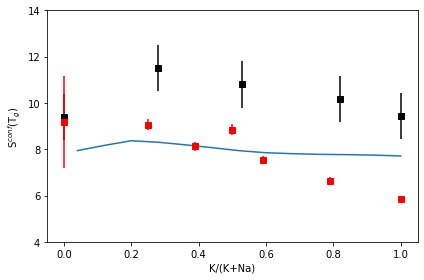

In [49]:
plt.xlabel("K/(K+Na)")
plt.ylabel("S$^{conf}$(T$_g$)")
plt.ylim(4,14)

plt.errorbar(np.array([0,0.28,0.53,0.82,1.0]),np.array([32.91,40.31,37.81,35.59,32.99])/7.0*2.0,
    yerr = 1.0, fmt="ks",
    label="Richet, 1984")

## endmember silicate
na2o = np.arange(0.,0.125,0.01)
k2o = 0.125-na2o
sio2 = np.ones(len(na2o))*0.75
al2o3 = np.ones(len(na2o))*0.125

X_visu_ = np.vstack([sio2,al2o3,na2o,k2o]).T
X_visu_.shape

mm.predict_all(X_visu_,1000.0*np.ones((len(X_visu_),1)),532.0*np.ones((len(X_visu_),1)))

plt.plot(X_visu_[:,3]/(X_visu_[:,2]+X_visu_[:,3]),mm.sctg.mean(axis=1),label="NN model")

plt.xlabel("K/(K+Na)")
plt.ylabel("S$^{conf}$(T$_g$)")
plt.ylim(4,14)

plt.errorbar(np.array([0,0.25,0.39,0.50,0.59,0.79,1.00]),
             np.array([9.17,9.06,8.12,8.84,7.54,6.63,5.83]),
    yerr = np.array([2.,0.23,0.20,0.23,0.18,0.15,0.11]), fmt="s", color="r",
    label="Le Losq et al., 2017")

plt.tight_layout()

# Compare with Giordano

In [23]:
criterion = torch.nn.MSELoss()

mm_train = models(path, name_list, device)
mm_valid = models(path, name_list, device)
mm_test = models(path, name_list, device)

mm_train.predict_all(ds.x_visco_train,ds.T_visco_train,ds.lbd_ri_train)
mm_valid.predict_all(ds.x_visco_valid,ds.T_visco_valid,ds.lbd_ri_valid)
mm_test.predict_all(ds.x_visco_test,ds.T_visco_test,ds.lbd_ri_test)

y_ag_train = neuralmodel.ag(ds.x_visco_train,ds.T_visco_train)
y_ag_valid = neuralmodel.ag(ds.x_visco_valid,ds.T_visco_valid)
y_ag_test = neuralmodel.ag(ds.x_visco_test,ds.T_visco_test)

y_myega_train = neuralmodel.myega(ds.x_visco_train,ds.T_visco_train)
y_myega_valid = neuralmodel.myega(ds.x_visco_valid,ds.T_visco_valid)
y_myega_test = neuralmodel.myega(ds.x_visco_test,ds.T_visco_test)

y_am_train = neuralmodel.am(ds.x_visco_train,ds.T_visco_train)
y_am_valid = neuralmodel.am(ds.x_visco_valid,ds.T_visco_valid)
y_am_test = neuralmodel.am(ds.x_visco_test,ds.T_visco_test)

y_cg_train = neuralmodel.cg(ds.x_visco_train,ds.T_visco_train)
y_cg_valid = neuralmodel.cg(ds.x_visco_valid,ds.T_visco_valid)
y_cg_test = neuralmodel.cg(ds.x_visco_test,ds.T_visco_test)

ag_after_train = torch.sqrt(criterion(y_ag_train, ds.y_visco_train))
ag_after_valid = torch.sqrt(criterion(y_ag_valid, ds.y_visco_valid))
ag_after_test = torch.sqrt(criterion(y_ag_test, ds.y_visco_test))
print('AG train loss after training' , ag_after_train.item())
print('AG valid loss after training' , ag_after_valid.item())
print('AG test loss after training' , ag_after_test.item())
print('')

myega_after_train = torch.sqrt(criterion(y_myega_train, ds.y_visco_train))
myega_after_valid = torch.sqrt(criterion(y_myega_valid, ds.y_visco_valid))
myega_after_test = torch.sqrt(criterion(y_myega_test, ds.y_visco_test))
print('MYEGA train loss after training' , myega_after_train.item())
print('MYEGA valid loss after training' , myega_after_valid.item())
print('MYEGA test loss after training' , myega_after_test.item())
print('')

am_after_train = torch.sqrt(criterion(y_am_train, ds.y_visco_train))
am_after_valid = torch.sqrt(criterion(y_am_valid, ds.y_visco_valid))
am_after_test = torch.sqrt(criterion(y_am_test, ds.y_visco_test))
print('am train loss after training' , am_after_train.item())
print('am valid loss after training' , am_after_valid.item())
print('am test loss after training' , am_after_test.item())
print('')

cg_after_train = torch.sqrt(criterion(y_cg_train, ds.y_visco_train))
cg_after_valid = torch.sqrt(criterion(y_cg_valid, ds.y_visco_valid))
cg_after_test = torch.sqrt(criterion(y_cg_test, ds.y_visco_test))
print('CG train loss after training' , cg_after_train.item())
print('CG valid loss after training' , cg_after_valid.item())
print('CG test loss after training' , cg_after_test.item())
print('')

table1 = pd.DataFrame()
table1["Training"] = [ag_after_train.item(), myega_after_train.item(), am_after_train.item(), cg_after_train.item()]
table1["Validation"] = [ag_after_valid.item(), myega_after_valid.item(), am_after_valid.item(), cg_after_valid.item()]
table1["Testing"] = [ag_after_test.item(), myega_after_test.item(), am_after_test.item(), cg_after_test.item()]
table1.rename(index={0:'Adam-Gibbs',1:'MYEGA',2:'Avramov-Milchev',3:'CG Free Volume'}, inplace=True)
table1.to_csv("./manuscript/table1.csv")

AG train loss after training 0.3021130859851837
AG valid loss after training 0.36226171255111694
AG test loss after training 0.575119137763977

MYEGA train loss after training 0.273379385471344
MYEGA valid loss after training 0.3943544626235962
MYEGA test loss after training 0.5591895580291748

am train loss after training 0.2702448070049286
am valid loss after training 0.3668685257434845
am test loss after training 0.5762985348701477

CG train loss after training 0.26313602924346924
CG valid loss after training 0.39714890718460083
CG test loss after training 0.5609568357467651



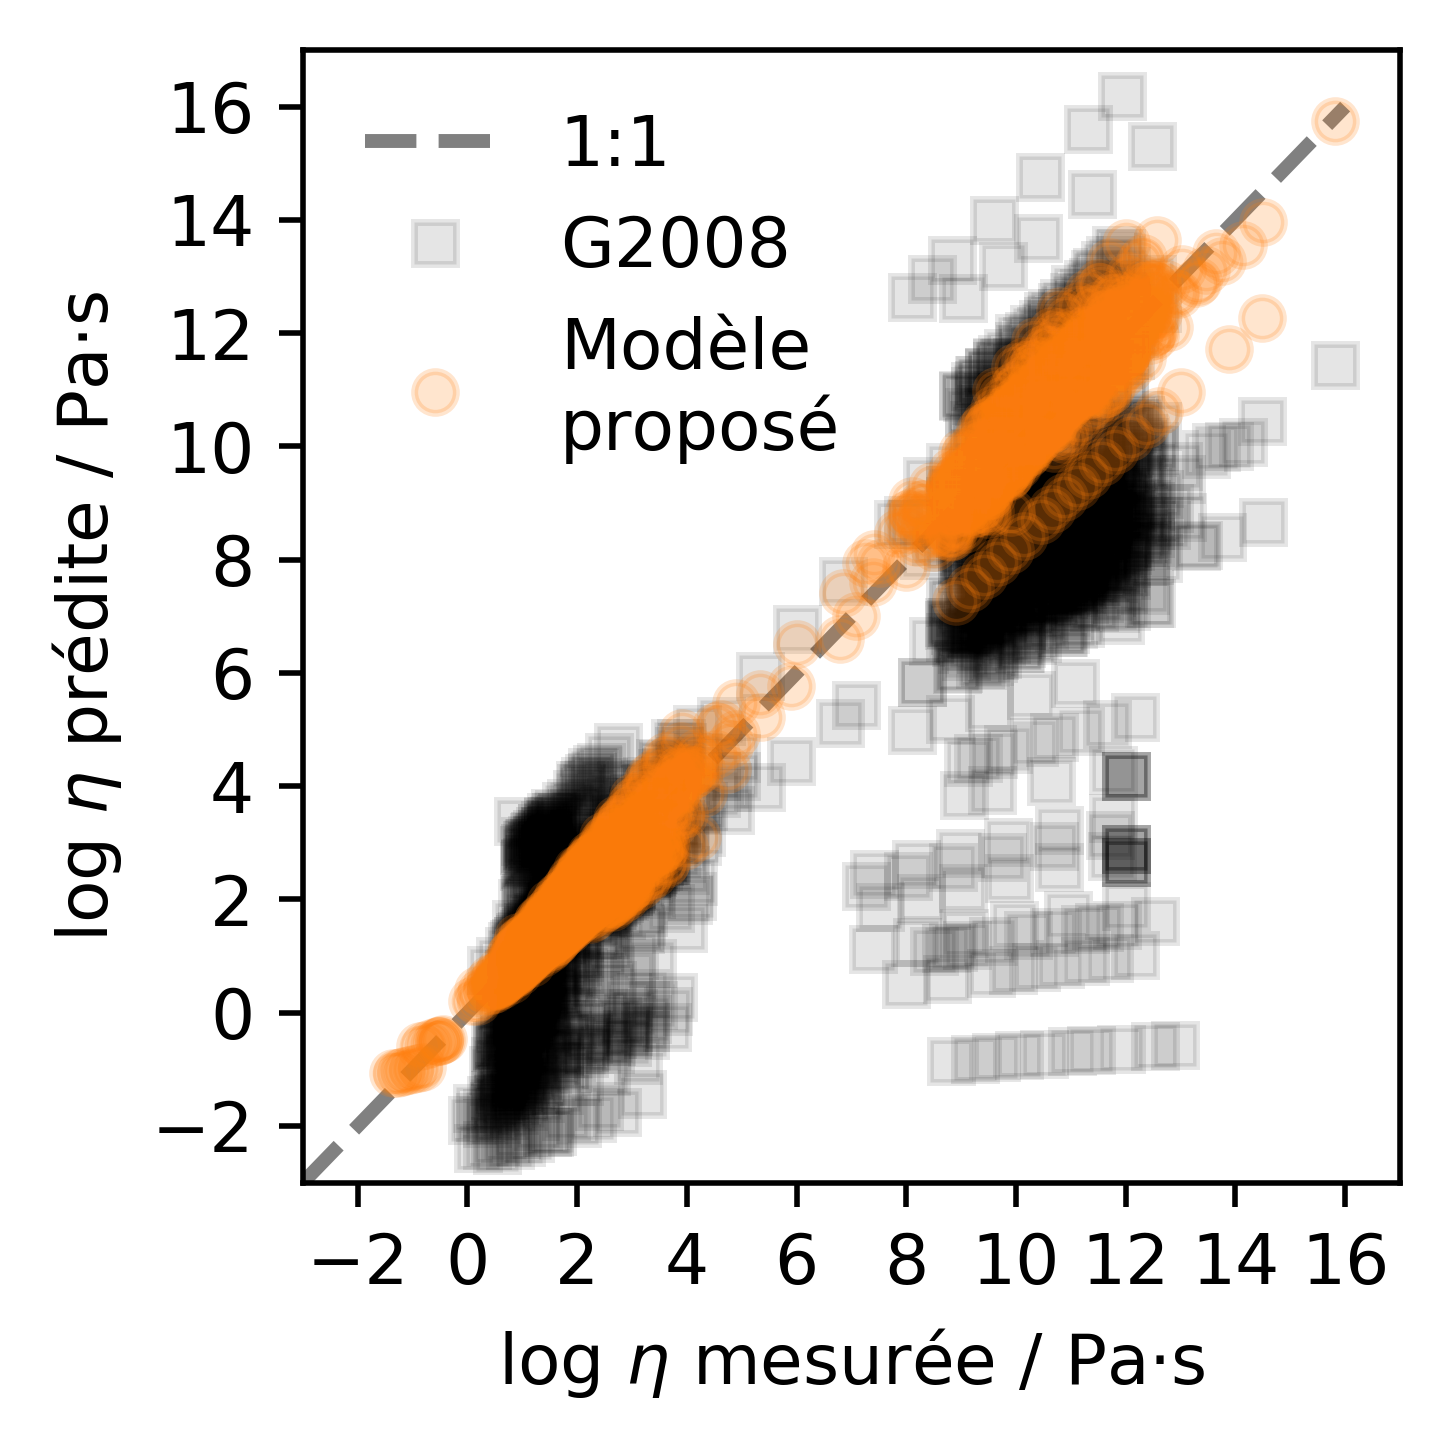

In [24]:
datas_ = pd.read_excel("./data/Database_IPGP.xlsx",sheet_name="VISCO")
datas_ = spy.chimie_control(datas_)
Gmodel = vp.G2008(datas_)

plt.figure(figsize=(3.,3.),dpi=500)

plt.plot([-3,16],[-3,16],"--",color="grey",linewidth=2,label="1:1")

plt.plot(datas_.viscosity,Gmodel[0],"ks",alpha=0.1,label="G2008")

plt.xticks([-2,0,2,4,6,8,10,12,14,16])
plt.yticks([-2,0,2,4,6,8,10,12,14,16])

plt.xlim(-3,17)
plt.ylim(-3,17)

plt.ylabel("log $\eta$ prédite / Pa$\cdot$s")
plt.xlabel("log $\eta$ mesurée / Pa$\cdot$s")

plt.legend(frameon=False)
plt.tight_layout()
plt.savefig("./figures/Comp_G2008.png")

plt.plot(ds.y_visco_train.cpu().detach().numpy(),y_ag_train.cpu().detach().numpy(),"o",color="C1",alpha=0.2,label="Modèle\nproposé")
plt.plot(ds.y_visco_valid.cpu().detach().numpy(),y_ag_valid.cpu().detach().numpy(),"o",color="C1",alpha=0.2)
plt.plot(ds.y_visco_test.cpu().detach().numpy(),y_ag_test.cpu().detach().numpy(),"o",color="C1",alpha=0.2)
plt.legend(frameon=False)
plt.savefig("./figures/Comp_G2008_LL.png")


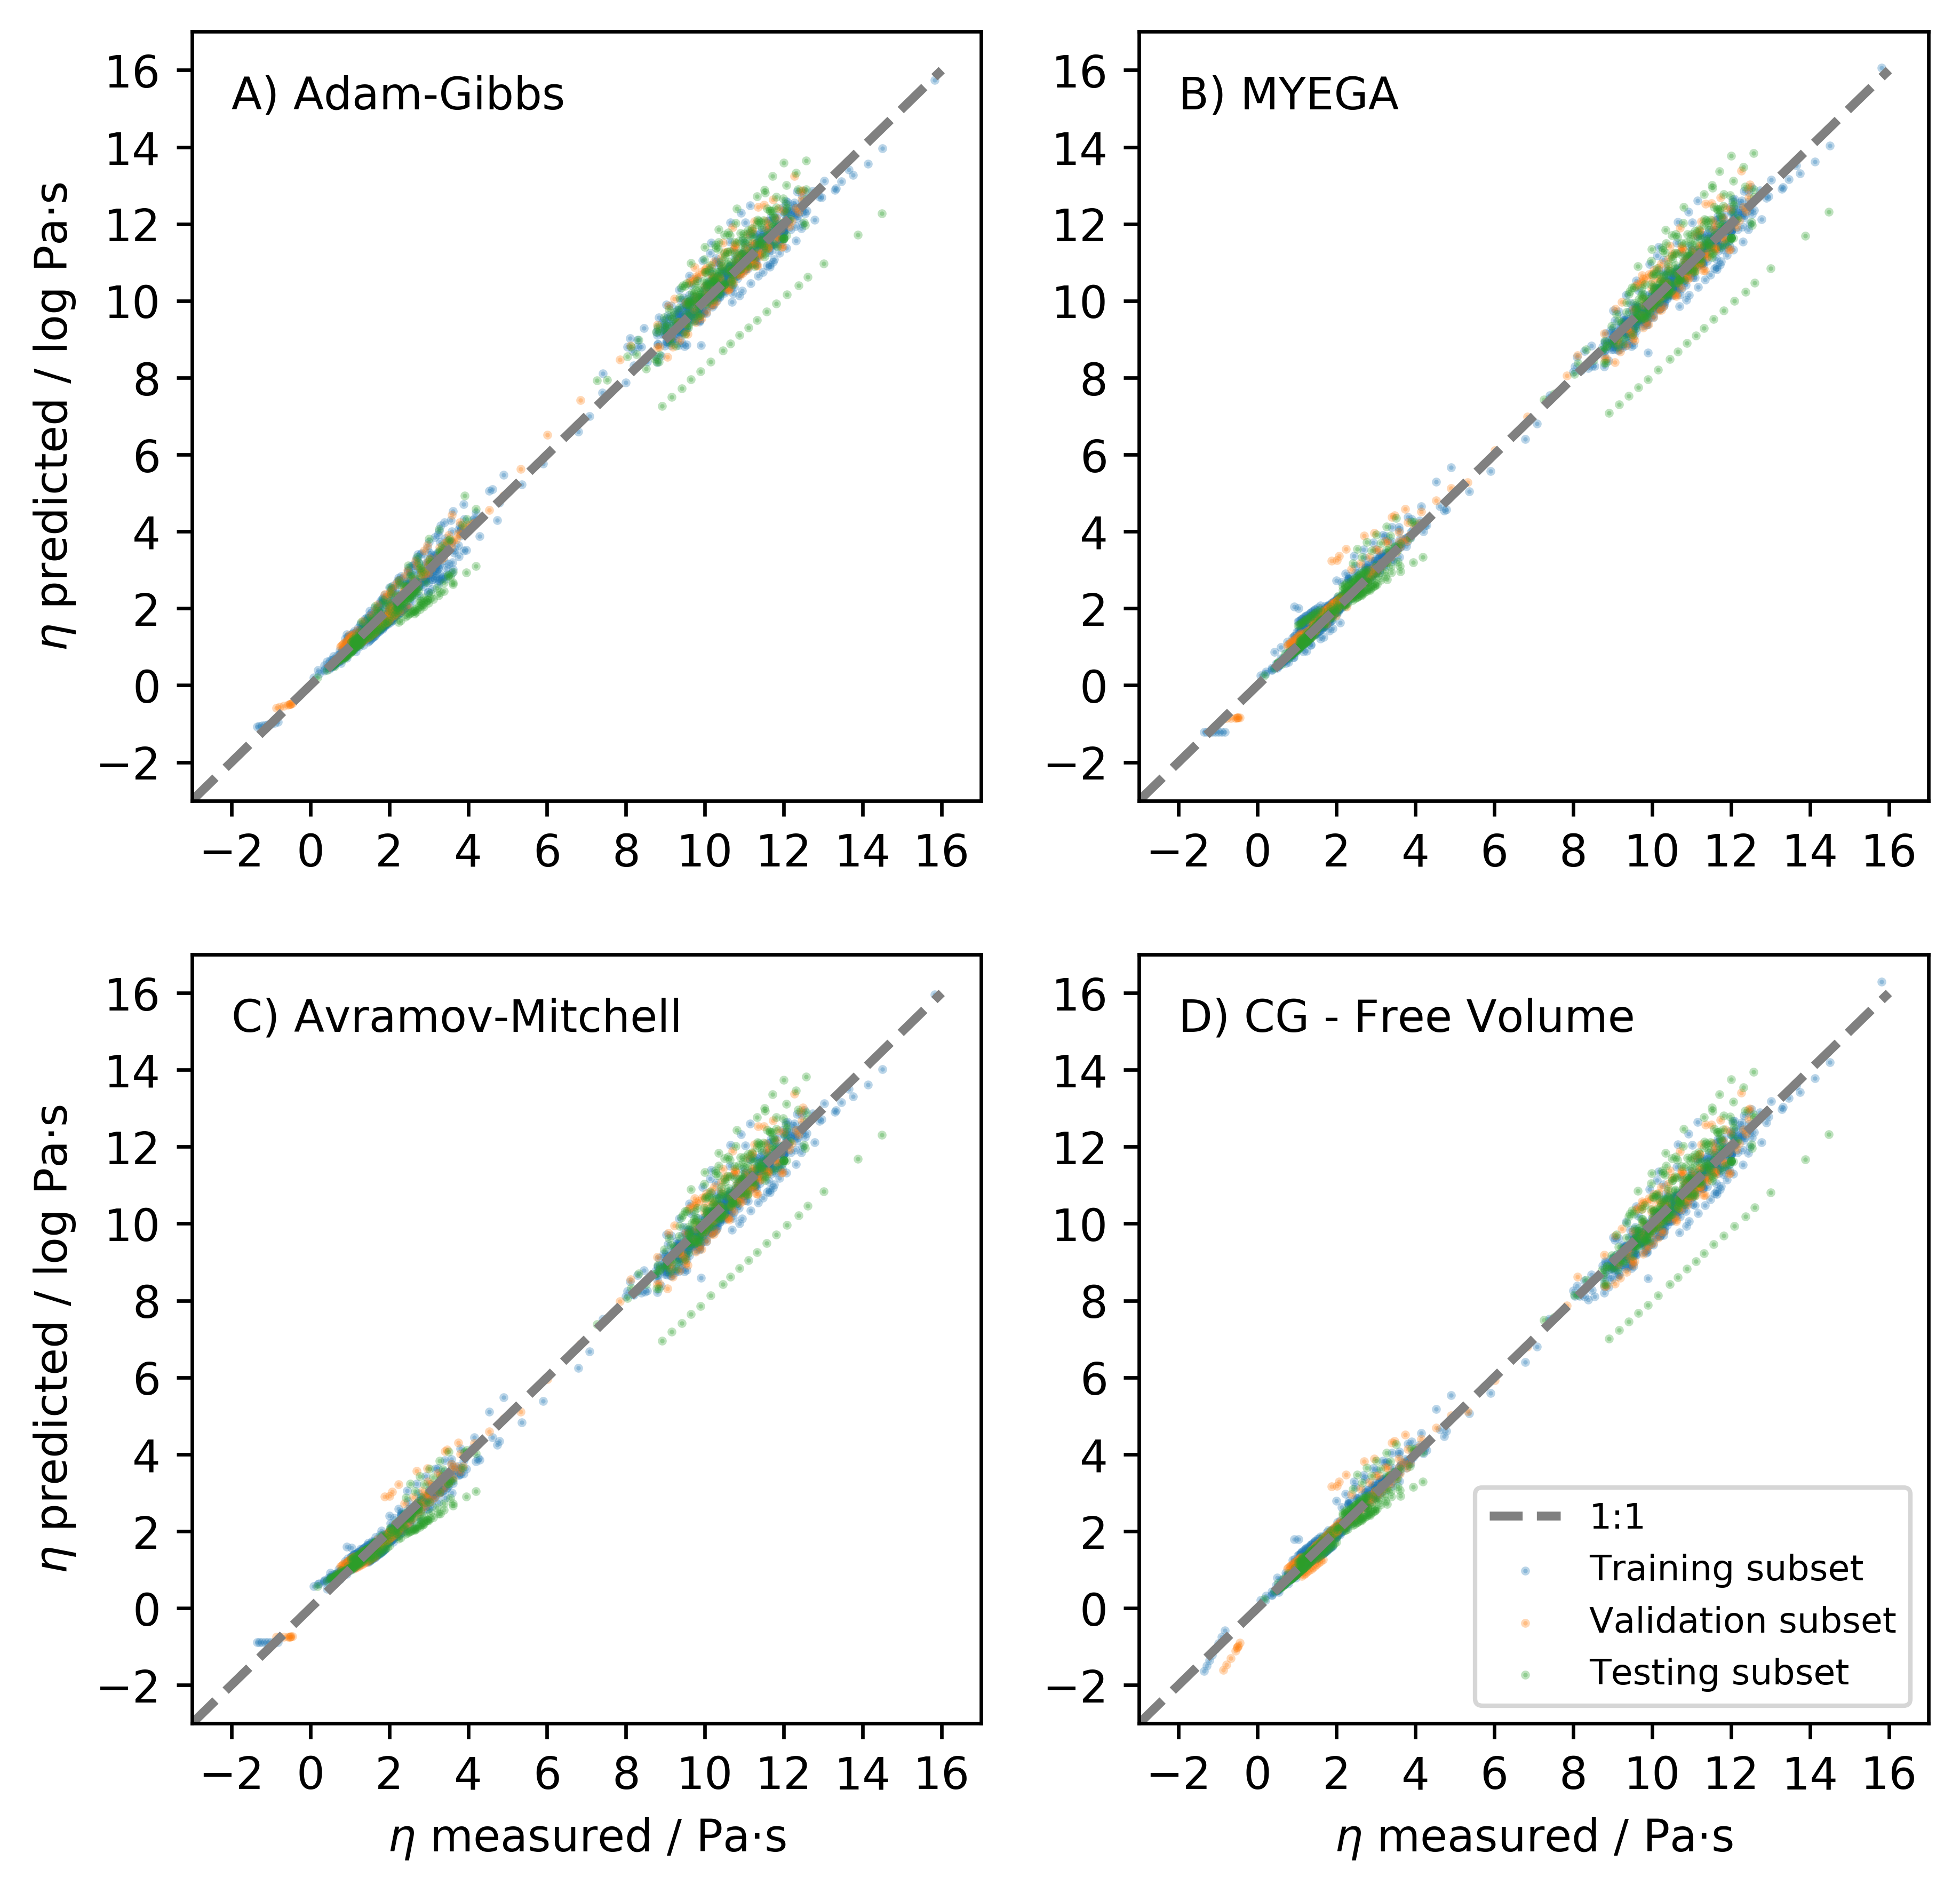

In [25]:
plt.figure(figsize=(7,7),dpi=600)

plt.subplot(2,2,1)
plt.scatter(ds.y_visco_train.cpu().detach().numpy(),y_ag_train.cpu().detach().numpy(),s=1,alpha=0.3,label="Train")
plt.scatter(ds.y_visco_valid.cpu().detach().numpy(),y_ag_valid.cpu().detach().numpy(),s=1,alpha=0.3,label="Valid")
plt.scatter(ds.y_visco_test.cpu().detach().numpy(),y_ag_test.cpu().detach().numpy(),s=1,alpha=0.3,label="Test")

plt.plot([-3,16],[-3,16],"--",color="grey",linewidth=2)

plt.xlim(-3,17)
plt.ylim(-3,17)

plt.xticks(np.arange(-2,18,2))
plt.yticks(np.arange(-2,18,2))

plt.ylabel("$\eta$ predicted / log Pa$\cdot$s")

plt.annotate("A) Adam-Gibbs",xy=(0.05,0.9),xycoords="axes fraction",ha="left")

plt.subplot(2,2,2)
plt.scatter(ds.y_visco_train.cpu().detach().numpy(),y_myega_train.cpu().detach().numpy(),s=1,alpha=0.3,label="Train")
plt.scatter(ds.y_visco_valid.cpu().detach().numpy(),y_myega_valid.cpu().detach().numpy(),s=1,alpha=0.3,label="Valid")
plt.scatter(ds.y_visco_test.cpu().detach().numpy(),y_myega_test.cpu().detach().numpy(),s=1,alpha=0.3,label="Test")

plt.plot([-3,16],[-3,16],"--",color="grey",linewidth=2,label="1:1")

plt.xlim(-3,17)
plt.ylim(-3,17)

plt.xticks(np.arange(-2,18,2))
plt.yticks(np.arange(-2,18,2))

plt.annotate("B) MYEGA",xy=(0.05,0.9),xycoords="axes fraction",ha="left")

plt.subplot(2,2,3)
plt.scatter(ds.y_visco_train.cpu().detach().numpy(),y_am_train.cpu().detach().numpy(),s=1,alpha=0.3,label="Training data subset")
plt.scatter(ds.y_visco_valid.cpu().detach().numpy(),y_am_valid.cpu().detach().numpy(),s=1,alpha=0.3,label="Validation data subset\n(used to stop training)")
plt.scatter(ds.y_visco_test.cpu().detach().numpy(),y_am_test.cpu().detach().numpy(),s=1,alpha=0.3,label="Testing data subset\n(never seen during training)")

plt.plot([-3,16],[-3,16],"--",color="grey",linewidth=2,label="1:1")

plt.xlim(-3,17)
plt.ylim(-3,17)

plt.xticks(np.arange(-2,18,2))
plt.yticks(np.arange(-2,18,2))

plt.xlabel("$\eta$ measured / Pa$\cdot$s")
plt.ylabel("$\eta$ predicted / log Pa$\cdot$s")
plt.annotate("C) Avramov-Mitchell ",xy=(0.05,0.9),xycoords="axes fraction",ha="left")

plt.subplot(2,2,4)
plt.scatter(ds.y_visco_train.cpu().detach().numpy(),y_cg_train.cpu().detach().numpy(),s=1,alpha=0.3,
            label="Training subset")
plt.scatter(ds.y_visco_valid.cpu().detach().numpy(),y_cg_valid.cpu().detach().numpy(),s=1,alpha=0.3,
            label="Validation subset")
plt.scatter(ds.y_visco_test.cpu().detach().numpy(),y_cg_test.cpu().detach().numpy(),s=1,alpha=0.3,
            label="Testing subset")

plt.plot([-3,16],[-3,16],"--",color="grey",linewidth=2,label="1:1")

plt.xlim(-3,17)
plt.ylim(-3,17)

plt.xticks(np.arange(-2,18,2))
plt.yticks(np.arange(-2,18,2))

plt.xlabel("$\eta$ measured / Pa$\cdot$s")
plt.annotate("D) CG - Free Volume ",xy=(0.05,0.9),xycoords="axes fraction",ha="left")

plt.legend(loc="lower right", fontsize=8)

plt.xlabel("$\eta$ measured / Pa$\cdot$s")

#plt.tight_layout()
plt.savefig("./figures/Viscosity_models.png")

Checking shape...
(50, 4)


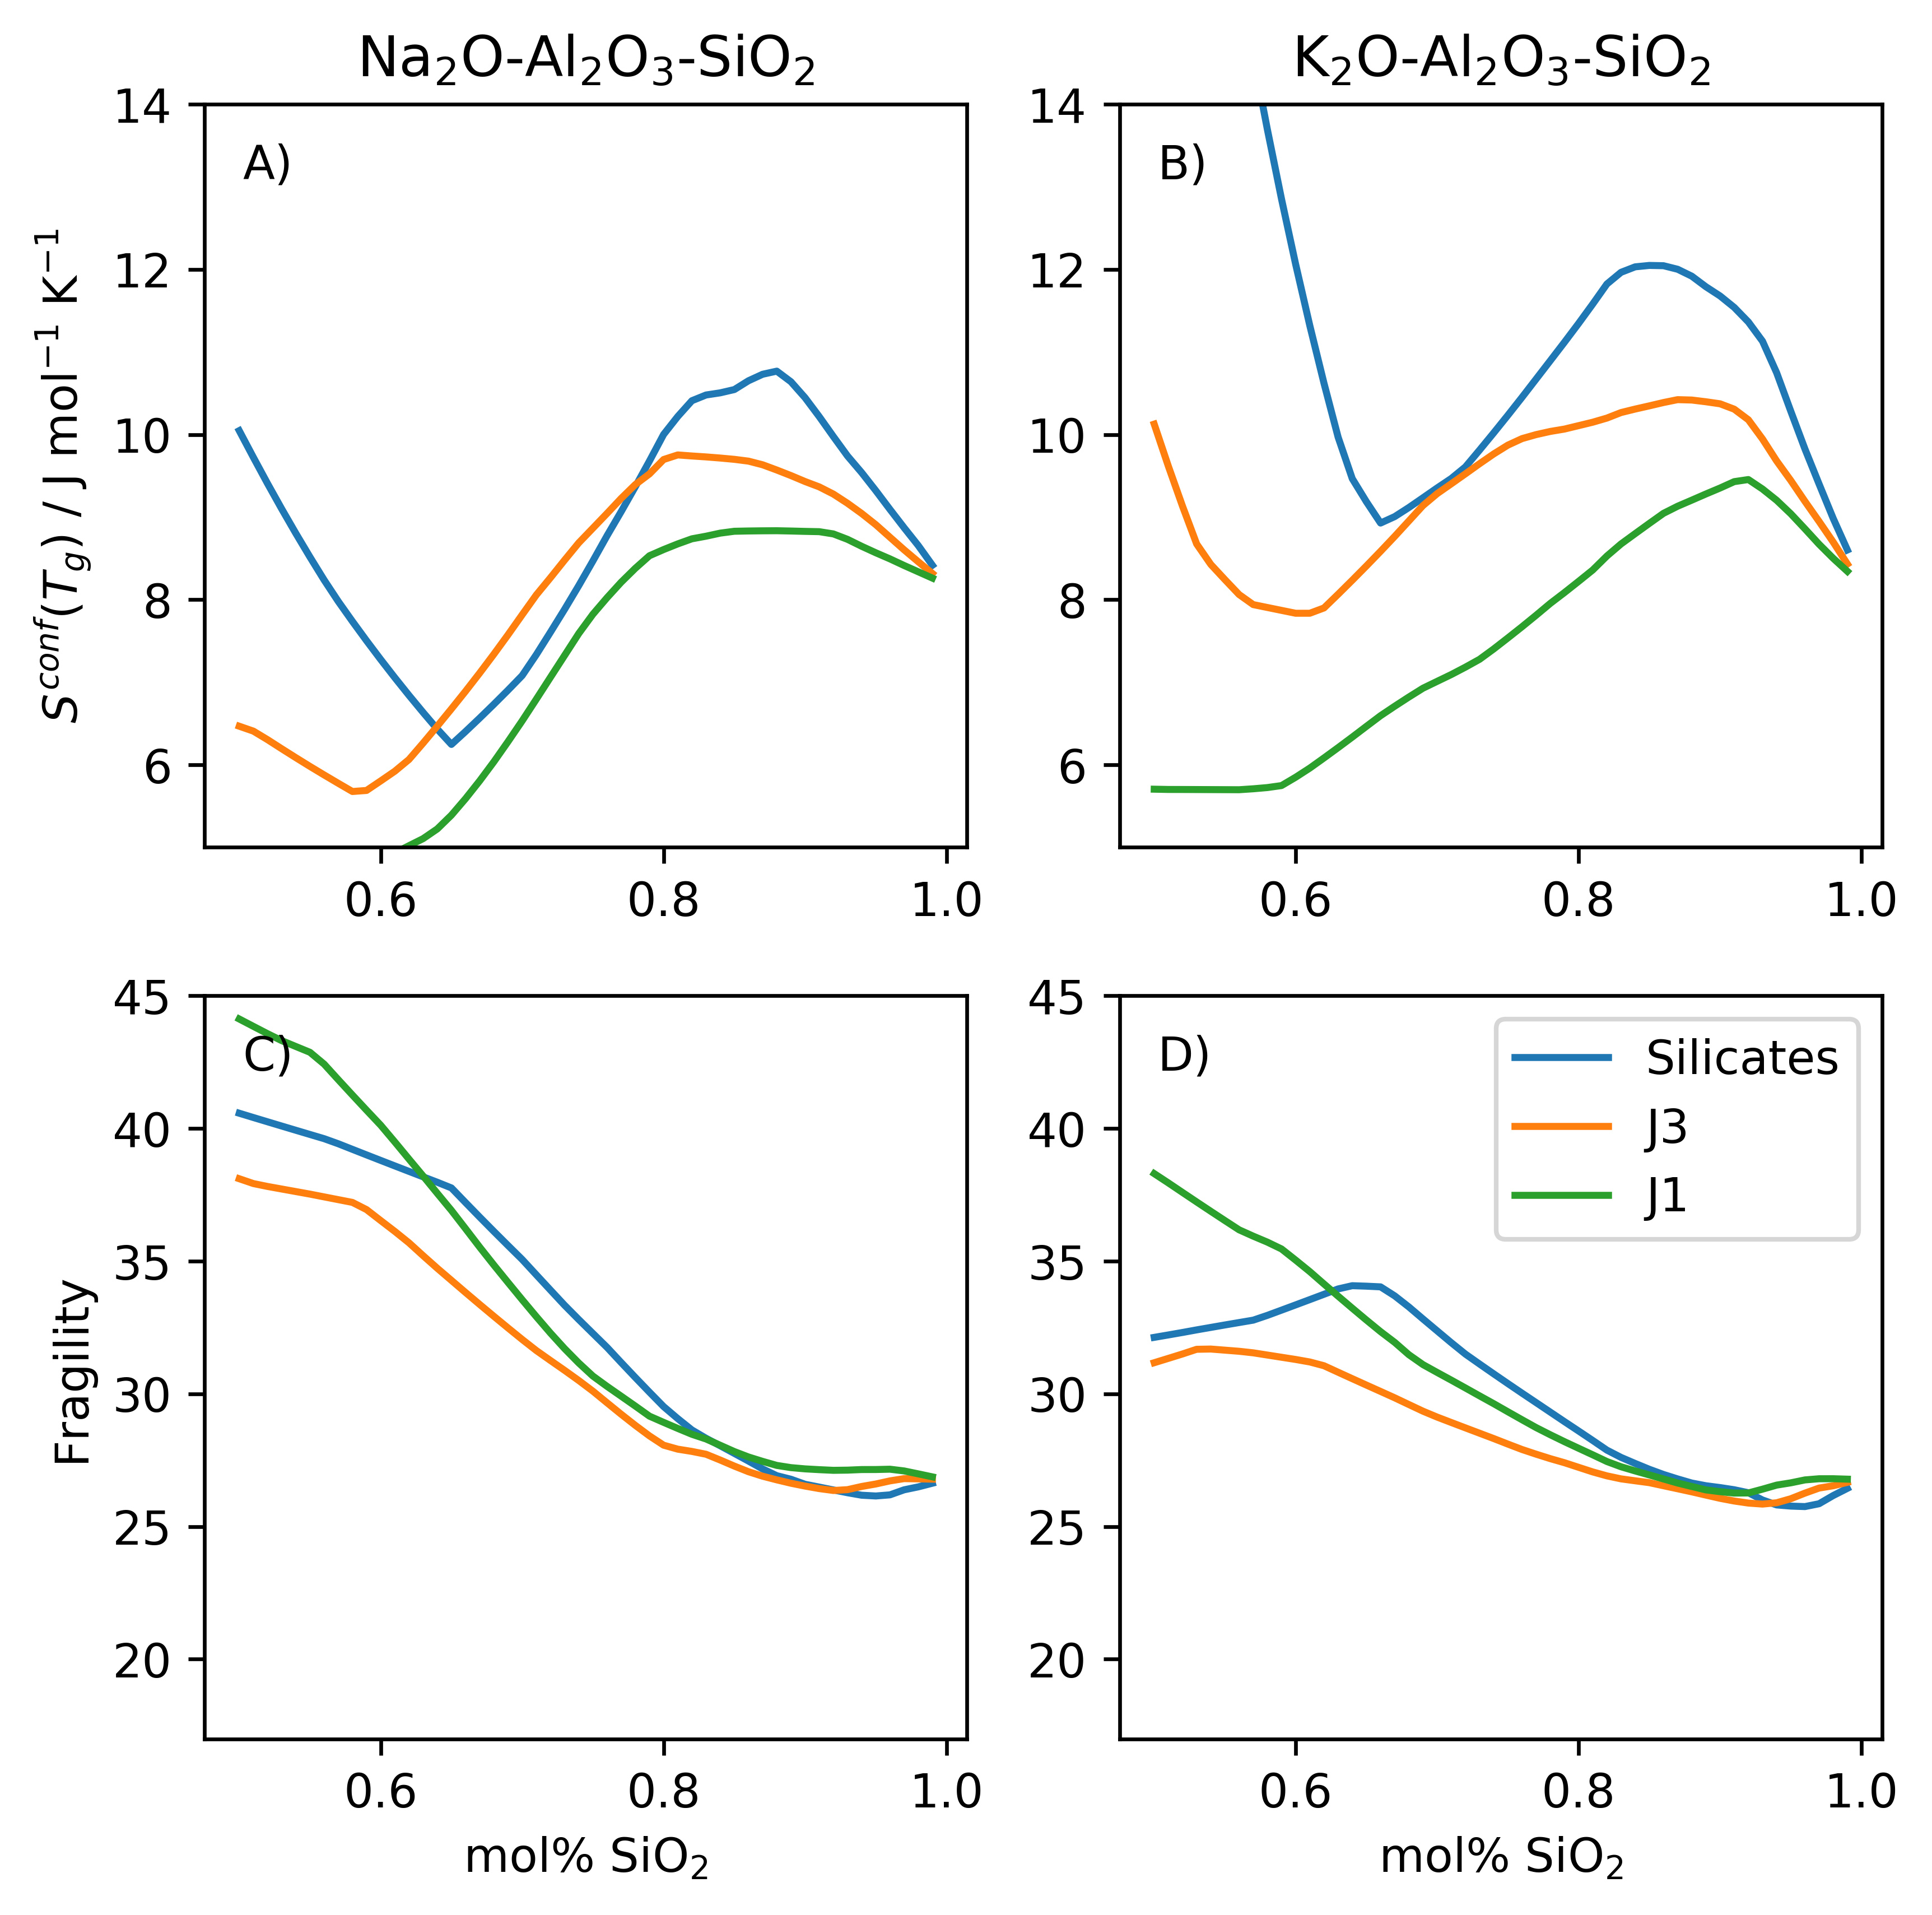

In [26]:
sio2 = np.arange(0.5,1.,0.01)

# order => sio2 al2o3 na2o k2o
X_visu_NAS_sili = np.vstack([sio2,np.zeros(len(sio2)),1.0-sio2,np.zeros(len(sio2))]).T
X_visu_NAS_J3 = np.vstack([sio2,(1.0-sio2)*1.0/3.0, (1.0-sio2)*2.0/3.0,np.zeros(len(sio2))]).T
X_visu_NAS_J1 = np.vstack([sio2,(1.0-sio2)*0.5, (1.0-sio2)*0.5,np.zeros(len(sio2))]).T

X_visu_KAS_sili = np.vstack([sio2,np.zeros(len(sio2)),np.zeros(len(sio2)),1.0-sio2]).T
X_visu_KAS_J3 = np.vstack([sio2,(1.0-sio2)*1.0/3.0,np.zeros(len(sio2)), (1.0-sio2)*2.0/3.0]).T
X_visu_KAS_J1 = np.vstack([sio2,(1.0-sio2)*0.5,np.zeros(len(sio2)), (1.0-sio2)*0.5]).T

Sctg_NAS_sili = neuralmodel.sctg(torch.Tensor(X_visu_NAS_sili).to(device)).cpu().detach().numpy()
Sctg_NAS_J3 = neuralmodel.sctg(torch.Tensor(X_visu_NAS_J3).to(device)).cpu().detach().numpy()
Sctg_NAS_J1 = neuralmodel.sctg(torch.Tensor(X_visu_NAS_J1).to(device)).cpu().detach().numpy()

Sctg_KAS_sili = neuralmodel.sctg(torch.Tensor(X_visu_KAS_sili).to(device)).cpu().detach().numpy()
Sctg_KAS_J3 = neuralmodel.sctg(torch.Tensor(X_visu_KAS_J3).to(device)).cpu().detach().numpy()
Sctg_KAS_J1 = neuralmodel.sctg(torch.Tensor(X_visu_KAS_J1).to(device)).cpu().detach().numpy()

tg_NAS_sili = neuralmodel.tg(torch.Tensor(X_visu_NAS_sili).to(device)).cpu().detach().numpy()
tg_NAS_J3 = neuralmodel.tg(torch.Tensor(X_visu_NAS_J3).to(device)).cpu().detach().numpy()
tg_NAS_J1 = neuralmodel.tg(torch.Tensor(X_visu_NAS_J1).to(device)).cpu().detach().numpy()

tg_KAS_sili = neuralmodel.tg(torch.Tensor(X_visu_KAS_sili).to(device)).cpu().detach().numpy()
tg_KAS_J3 = neuralmodel.tg(torch.Tensor(X_visu_KAS_J3).to(device)).cpu().detach().numpy()
tg_KAS_J1 = neuralmodel.tg(torch.Tensor(X_visu_KAS_J1).to(device)).cpu().detach().numpy()

m_NAS_sili = neuralmodel.fragility(torch.Tensor(X_visu_NAS_sili).to(device)).cpu().detach().numpy()
m_NAS_J3 = neuralmodel.fragility(torch.Tensor(X_visu_NAS_J3).to(device)).cpu().detach().numpy()
m_NAS_J1 = neuralmodel.fragility(torch.Tensor(X_visu_NAS_J1).to(device)).cpu().detach().numpy()

m_KAS_sili = neuralmodel.fragility(torch.Tensor(X_visu_KAS_sili).to(device)).cpu().detach().numpy()
m_KAS_J3 = neuralmodel.fragility(torch.Tensor(X_visu_KAS_J3).to(device)).cpu().detach().numpy()
m_KAS_J1 = neuralmodel.fragility(torch.Tensor(X_visu_KAS_J1).to(device)).cpu().detach().numpy()

print("Checking shape...")
print(X_visu_KAS_J1.shape)

plt.figure(figsize=(6.44,6.44), dpi=600)

plt.subplot(2,2,1) # NAS entropy

plt.plot(X_visu_NAS_sili[:,0],Sctg_NAS_sili,color="C0",label="Silicates")
plt.plot(X_visu_NAS_J3[:,0],Sctg_NAS_J3,color="C1",label="J3")
plt.plot(X_visu_NAS_J1[:,0],Sctg_NAS_J1,color="C2",label="J1")

plt.title(r"Na$_2$O-Al$_2$O$_3$-SiO$_2$")
plt.ylabel("$S^{conf}(T_g)$ / J mol$^{-1}$ K$^{-1}$")
plt.annotate("A)",xy=(0.05,0.9),xycoords="axes fraction",ha="left")
plt.ylim(5,14)

plt.subplot(2,2,2) # KAS entropy

plt.plot(X_visu_KAS_sili[:,0],Sctg_KAS_sili,color="C0",label="Silicates")
plt.plot(X_visu_KAS_J3[:,0],Sctg_KAS_J3,color="C1",label="J3")
plt.plot(X_visu_KAS_J1[:,0],Sctg_KAS_J1,color="C2",label="J1")

plt.title(r"K$_2$O-Al$_2$O$_3$-SiO$_2$")
plt.annotate("B)",xy=(0.05,0.9),xycoords="axes fraction",ha="left")
plt.ylim(5,14)

plt.subplot(2,2,3) # NAS fragility

plt.plot(X_visu_NAS_sili[:,0],m_NAS_sili,color="C0",label="Silicates")
plt.plot(X_visu_NAS_J3[:,0],m_NAS_J3,color="C1",label="J3")
plt.plot(X_visu_NAS_J1[:,0],m_NAS_J1,color="C2",label="J1")

plt.xlabel("mol% SiO$_2$")
plt.ylabel("Fragility")
plt.annotate("C)",xy=(0.05,0.9),xycoords="axes fraction",ha="left")
plt.ylim(17,45)

plt.subplot(2,2,4) # KAS fragility

plt.plot(X_visu_KAS_sili[:,0],m_KAS_sili,color="C0",label="Silicates")
plt.plot(X_visu_KAS_J3[:,0],m_KAS_J3,color="C1",label="J3")
plt.plot(X_visu_KAS_J1[:,0],m_KAS_J1,color="C2",label="J1")
plt.ylim(17,45)

plt.xlabel("mol% SiO$_2$")
plt.annotate("D)",xy=(0.05,0.9),xycoords="axes fraction",ha="left")

plt.legend(loc="upper right")

plt.savefig("./figures/Entropy_J_KNAS.png")

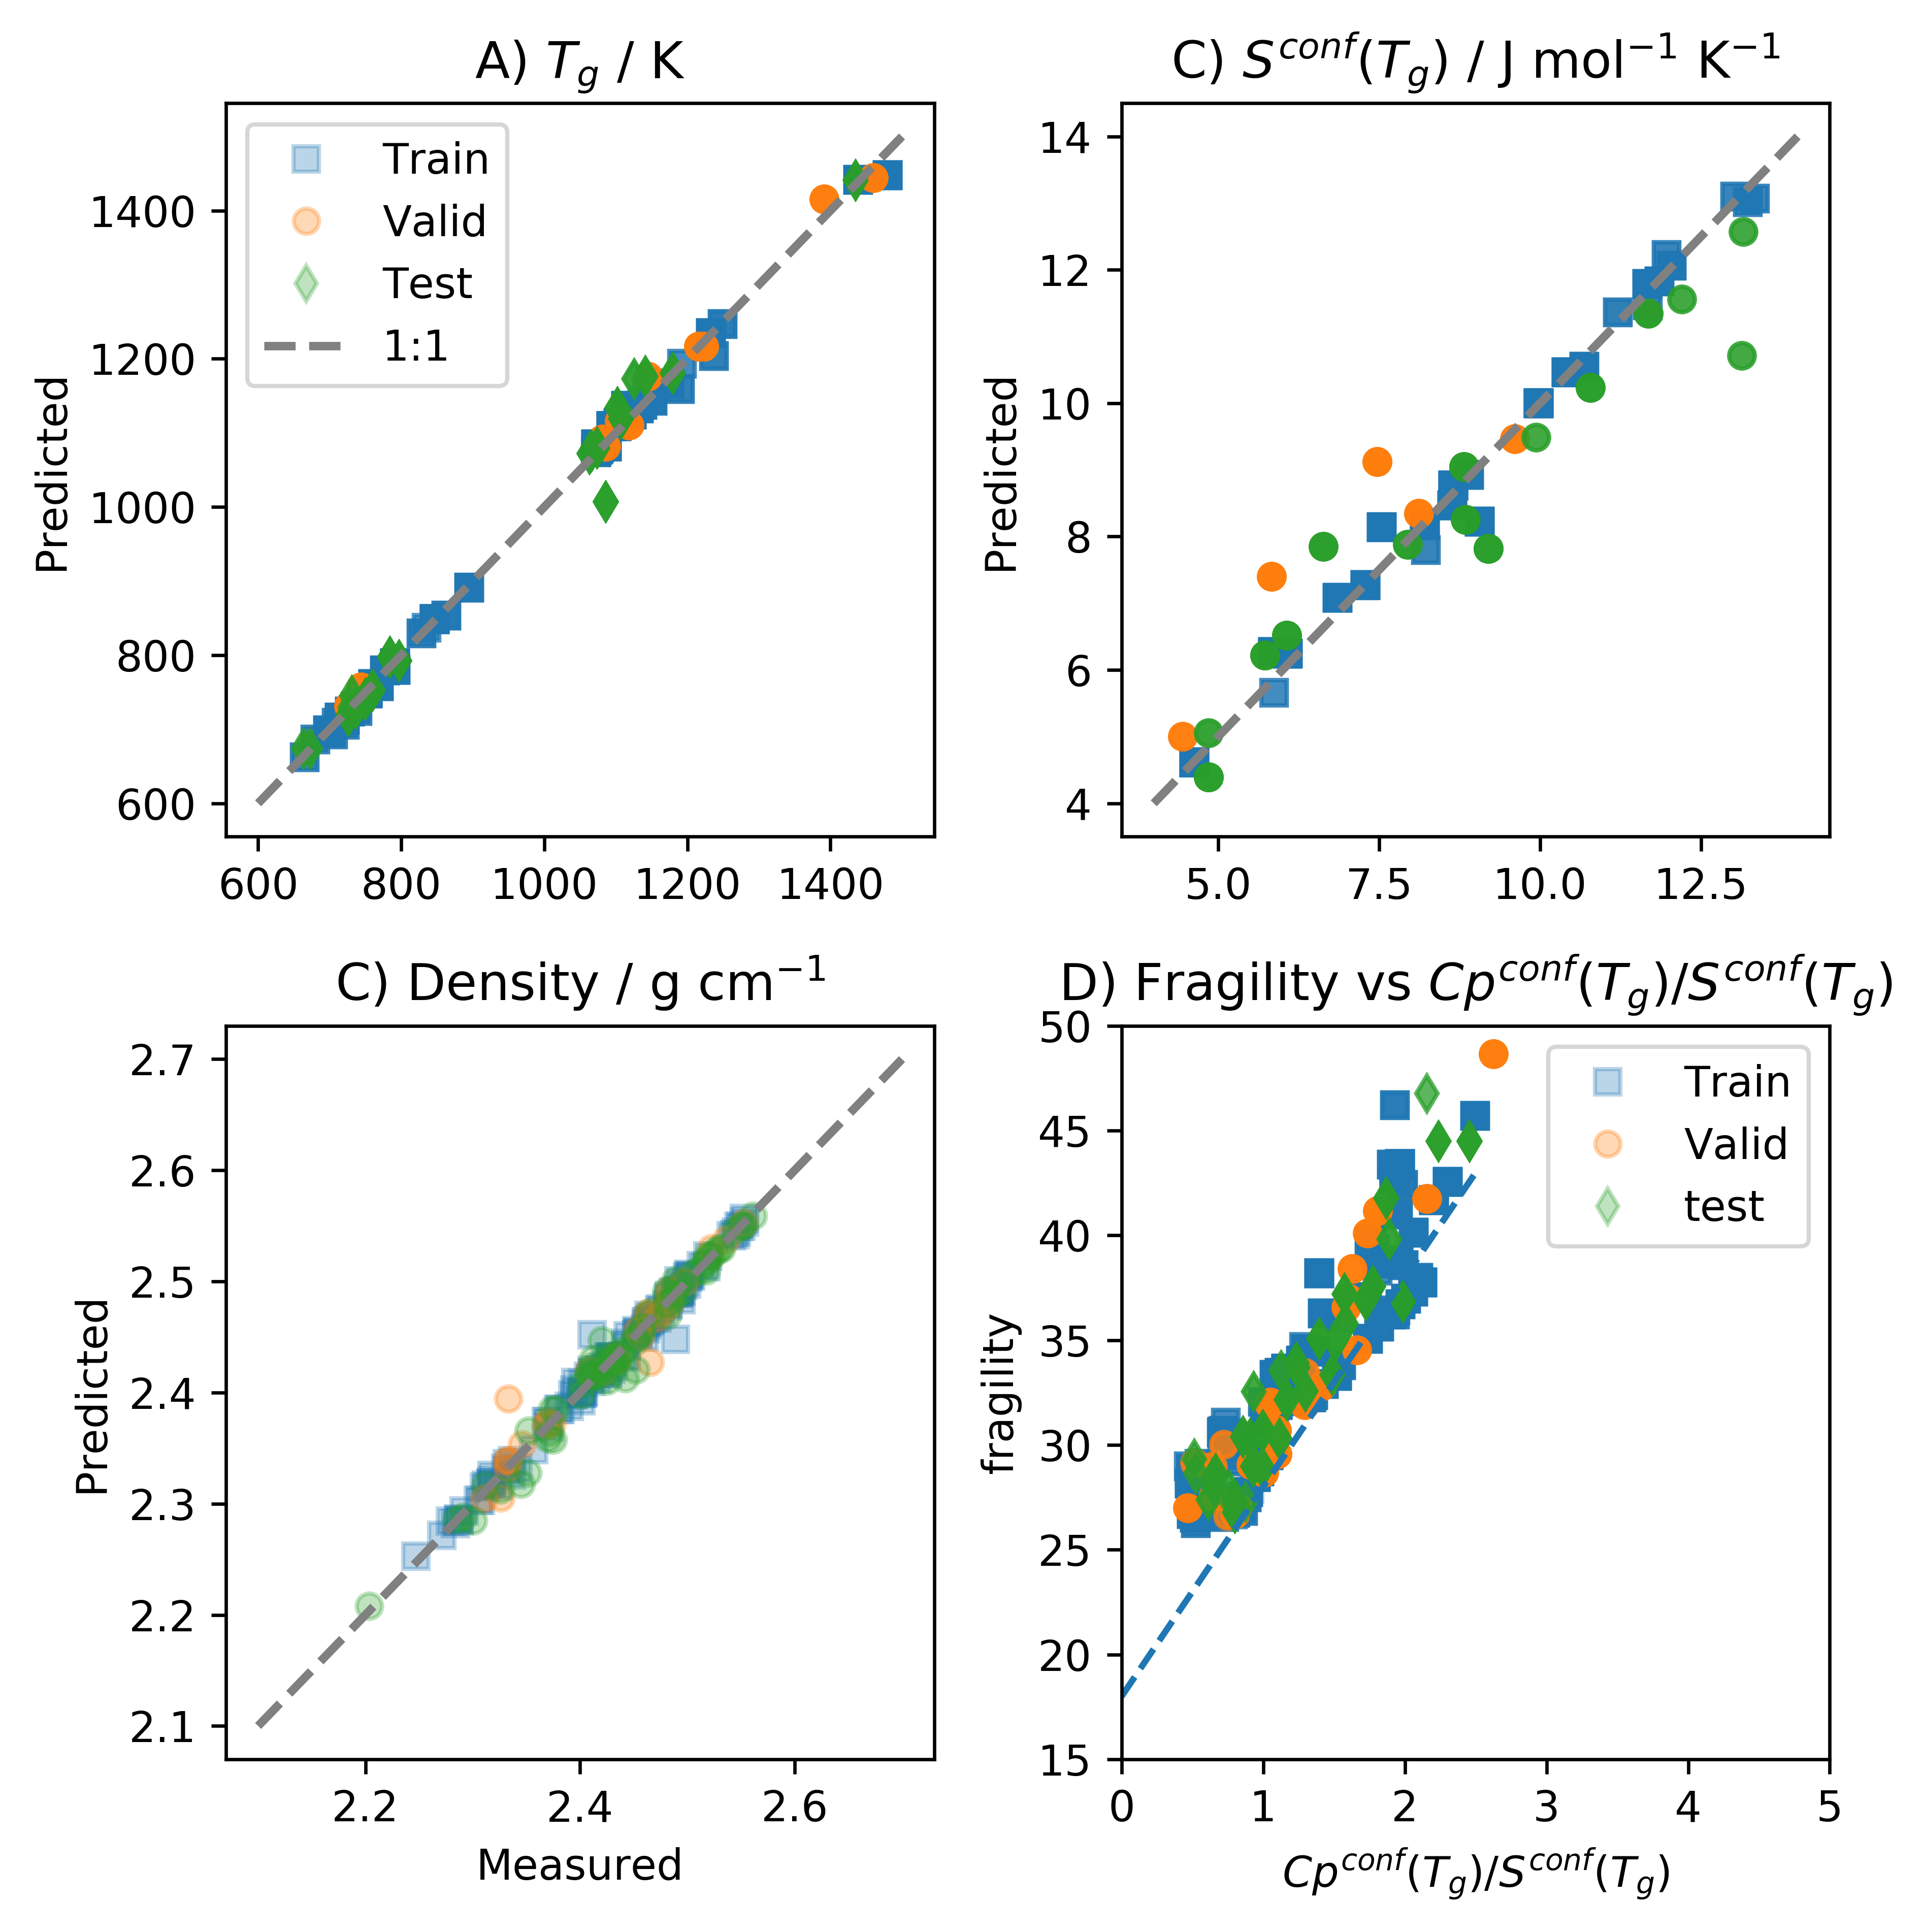

In [27]:
plt.figure(figsize=(6.44,6.44),dpi=600)

plt.subplot(2,2,1)
plt.plot(ds.y_tg_train.cpu().detach().numpy(),neuralmodel.tg(ds.x_tg_train).cpu().detach().numpy(),marker="s",linestyle="none",color="C0",alpha=0.3,label="Train")
plt.plot(ds.y_tg_valid.cpu().detach().numpy(),neuralmodel.tg(ds.x_tg_valid).cpu().detach().numpy(),"o",color="C1",alpha=0.3,label="Valid")
plt.plot(ds.y_tg_test.cpu().detach().numpy(),neuralmodel.tg(ds.x_tg_test).cpu().detach().numpy(),"d",color="C2",alpha=0.3,label="Test")

plt.ylabel("Predicted")
plt.title(r"A) $T_g$ / K")

plt.plot([600,1500],[600,1500],"--",color="grey",linewidth=2,label="1:1")

plt.legend(loc="upper left")

plt.subplot(2,2,2)
plt.plot(ds.y_entro_train.cpu().detach().numpy(),neuralmodel.sctg(ds.x_entro_train).cpu().detach().numpy(),"s",color="C0",alpha=0.3,label="Train")
plt.plot(ds.y_entro_valid.cpu().detach().numpy(),neuralmodel.sctg(ds.x_entro_valid).cpu().detach().numpy(),"o",color="C1",alpha=0.3,label="Valid")
plt.plot(ds.y_entro_test.cpu().detach().numpy(),neuralmodel.sctg(ds.x_entro_test).cpu().detach().numpy(),"o",color="C2",alpha=0.3,label="Test")
plt.ylabel("Predicted")
plt.title(r"C) $S^{conf}(T_g)$ / J mol$^{-1}$ K$^{-1}$")

plt.plot([4,14],[4,14],"--",color="grey",linewidth=2,label="1:1")

plt.subplot(2,2,3)
plt.plot(ds.y_density_train.cpu().detach().numpy(),neuralmodel.density(ds.x_density_train).cpu().detach().numpy(),"s",color="C0",alpha=0.3,label="Train")
plt.plot(ds.y_density_valid.cpu().detach().numpy(),neuralmodel.density(ds.x_density_valid).cpu().detach().numpy(),"o",color="C1",alpha=0.3,label="Valid")
plt.plot(ds.y_density_test.cpu().detach().numpy(),neuralmodel.density(ds.x_density_test).cpu().detach().numpy(),"o",color="C2",alpha=0.3,label="Test")

plt.xlabel("Measured")
plt.ylabel("Predicted")
plt.title(r"C) Density / g cm$^{-1}$")

plt.plot([2.1,2.7],[2.1,2.7],"--",color="grey",linewidth=2,label="1:1")

plt.subplot(2,2,4)

# Train
Cpconf = neuralmodel.ap_calc(ds.x_visco_train) + neuralmodel.b_calc(ds.x_visco_train)* neuralmodel.tg(ds.x_visco_train)
Cp_S = Cpconf/neuralmodel.sctg(ds.x_visco_train)
plt.plot(Cp_S.cpu().detach().numpy(),
         neuralmodel.fragility(ds.x_visco_train).cpu().detach().numpy(),"s",color="C0",alpha=0.3,label="Train")

# Valid
Cpconf = neuralmodel.ap_calc(ds.x_visco_valid) + neuralmodel.b_calc(ds.x_visco_valid)* neuralmodel.tg(ds.x_visco_valid)
Cp_S = Cpconf/neuralmodel.sctg(ds.x_visco_valid)
plt.plot(Cp_S.cpu().detach().numpy(),
         neuralmodel.fragility(ds.x_visco_valid).cpu().detach().numpy(),"o",color="C1",alpha=0.3,label="Valid")

# Test
Cpconf = neuralmodel.ap_calc(ds.x_visco_test) + neuralmodel.b_calc(ds.x_visco_test)* neuralmodel.tg(ds.x_visco_test)
Cp_S = Cpconf/neuralmodel.sctg(ds.x_visco_test)
plt.plot(Cp_S.cpu().detach().numpy(),neuralmodel.fragility(ds.x_visco_test).cpu().detach().numpy(),"d",color="C2",alpha=0.3,label="test")

plt.plot([0, 2.5],[18., 18.+10*2.5],"--")

plt.xlabel(r"$Cp^{conf}(T_g)/S^{conf}(T_g)$")
plt.ylabel("fragility")

plt.title(r"D) Fragility vs $Cp^{conf}(T_g)/S^{conf}(T_g)$")

plt.xlim(0,5)
plt.ylim(15,50)

plt.legend()

plt.tight_layout()

plt.savefig("./figures/Pred_Mes_TgSDens.png")

# Raman figure

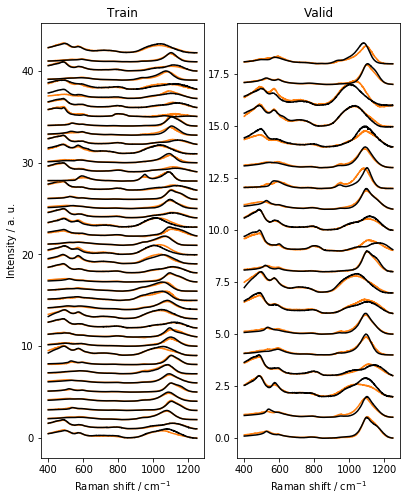

In [35]:
x_raman_shift = np.arange(400.,1250.,1.0) # our real x axis, for resampling

plt.figure(figsize=(6.44,8))

###
plt.subplot(1,2,1)
plt.title("Train")
Raman_error = 0.
shift = 0.
for i in range(ds.x_raman_train.shape[0]):
    Raman_error += np.sum((neuralmodel.raman_pred(ds.x_raman_train[i,:]).detach().numpy()-ds.y_raman_train[i,:].detach().numpy())**2)/np.sum(ds.y_raman_train[i,:].detach().numpy())
    plt.plot(x_raman_shift,neuralmodel.raman_pred(ds.x_raman_train[i,:]).detach().numpy()+shift,color="C1")
    plt.plot(x_raman_shift,ds.y_raman_train[i,:].detach().numpy()+shift,"k-")
    shift += 1.
plt.xlabel("Raman shift / cm$^{-1}$")
plt.ylabel("Intensity / a. u.")
Raman_error = Raman_error/ds.x_raman_train.shape[0]
###
plt.subplot(1,2,2)
plt.title("Valid")

shift = 0.
for i in range(ds.x_raman_valid.shape[0]):
    
    plt.plot(x_raman_shift,neuralmodel.raman_pred(ds.x_raman_valid[i,:]).detach().numpy()+shift,color="C1")
    plt.plot(x_raman_shift,ds.y_raman_valid[i,:].detach().numpy()+shift,"k-")
    shift += 1.

plt.xlabel("Raman shift / cm$^{-1}$")
plt.savefig("./figures/Raman_preds.pdf")

#idx_min_train = np.where(sp[:,1] == np.min(sp[(800<= sp[:,0])&(sp[:,0]<=1000),1]))[0][0]

Rr_train = np.trapz(ds.y_raman_train.detach().numpy()[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(ds.y_raman_train.detach().numpy()[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)
Rr_valid = np.trapz(ds.y_raman_valid.detach().numpy()[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(ds.y_raman_valid.detach().numpy()[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)

Rr_train_pred = np.trapz(neuralmodel.raman_pred(ds.x_raman_train).detach().numpy()[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(neuralmodel.raman_pred(ds.x_raman_train).detach().numpy()[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)
Rr_valid_pred = np.trapz(neuralmodel.raman_pred(ds.x_raman_valid).detach().numpy()[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(neuralmodel.raman_pred(ds.x_raman_valid).detach().numpy()[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)


In [11]:
visu_KAS_Raman_sili = neuralmodel.raman_pred(torch.FloatTensor(X_visu_KAS_sili).to(device)).cpu().detach().numpy()
visu_KAS_Raman_J3 = neuralmodel.raman_pred(torch.FloatTensor(X_visu_KAS_J3).to(device)).cpu().detach().numpy()
visu_KAS_Raman_J1 = neuralmodel.raman_pred(torch.FloatTensor(X_visu_KAS_J1).to(device)).cpu().detach().numpy()

visu_NAS_Raman_sili = neuralmodel.raman_pred(torch.FloatTensor(X_visu_NAS_sili).to(device)).cpu().detach().numpy()
visu_NAS_Raman_J3 = neuralmodel.raman_pred(torch.FloatTensor(X_visu_NAS_J3).to(device)).cpu().detach().numpy()
visu_NAS_Raman_J1 = neuralmodel.raman_pred(torch.FloatTensor(X_visu_NAS_J1).to(device)).cpu().detach().numpy()

Rr_KAS_sili = np.trapz(visu_KAS_Raman_sili[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(visu_KAS_Raman_sili[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)
Rr_KAS_J3 = np.trapz(visu_KAS_Raman_J3[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(visu_KAS_Raman_J3[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)
Rr_KAS_J1 = np.trapz(visu_KAS_Raman_J1[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(visu_KAS_Raman_J1[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)

Rr_NAS_sili = np.trapz(visu_NAS_Raman_sili[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(visu_NAS_Raman_sili[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)
Rr_NAS_J3 = np.trapz(visu_NAS_Raman_J3[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(visu_NAS_Raman_J3[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)
Rr_NAS_J1 = np.trapz(visu_NAS_Raman_J1[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(visu_NAS_Raman_J1[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)


<Figure size 1080x1080 with 0 Axes>

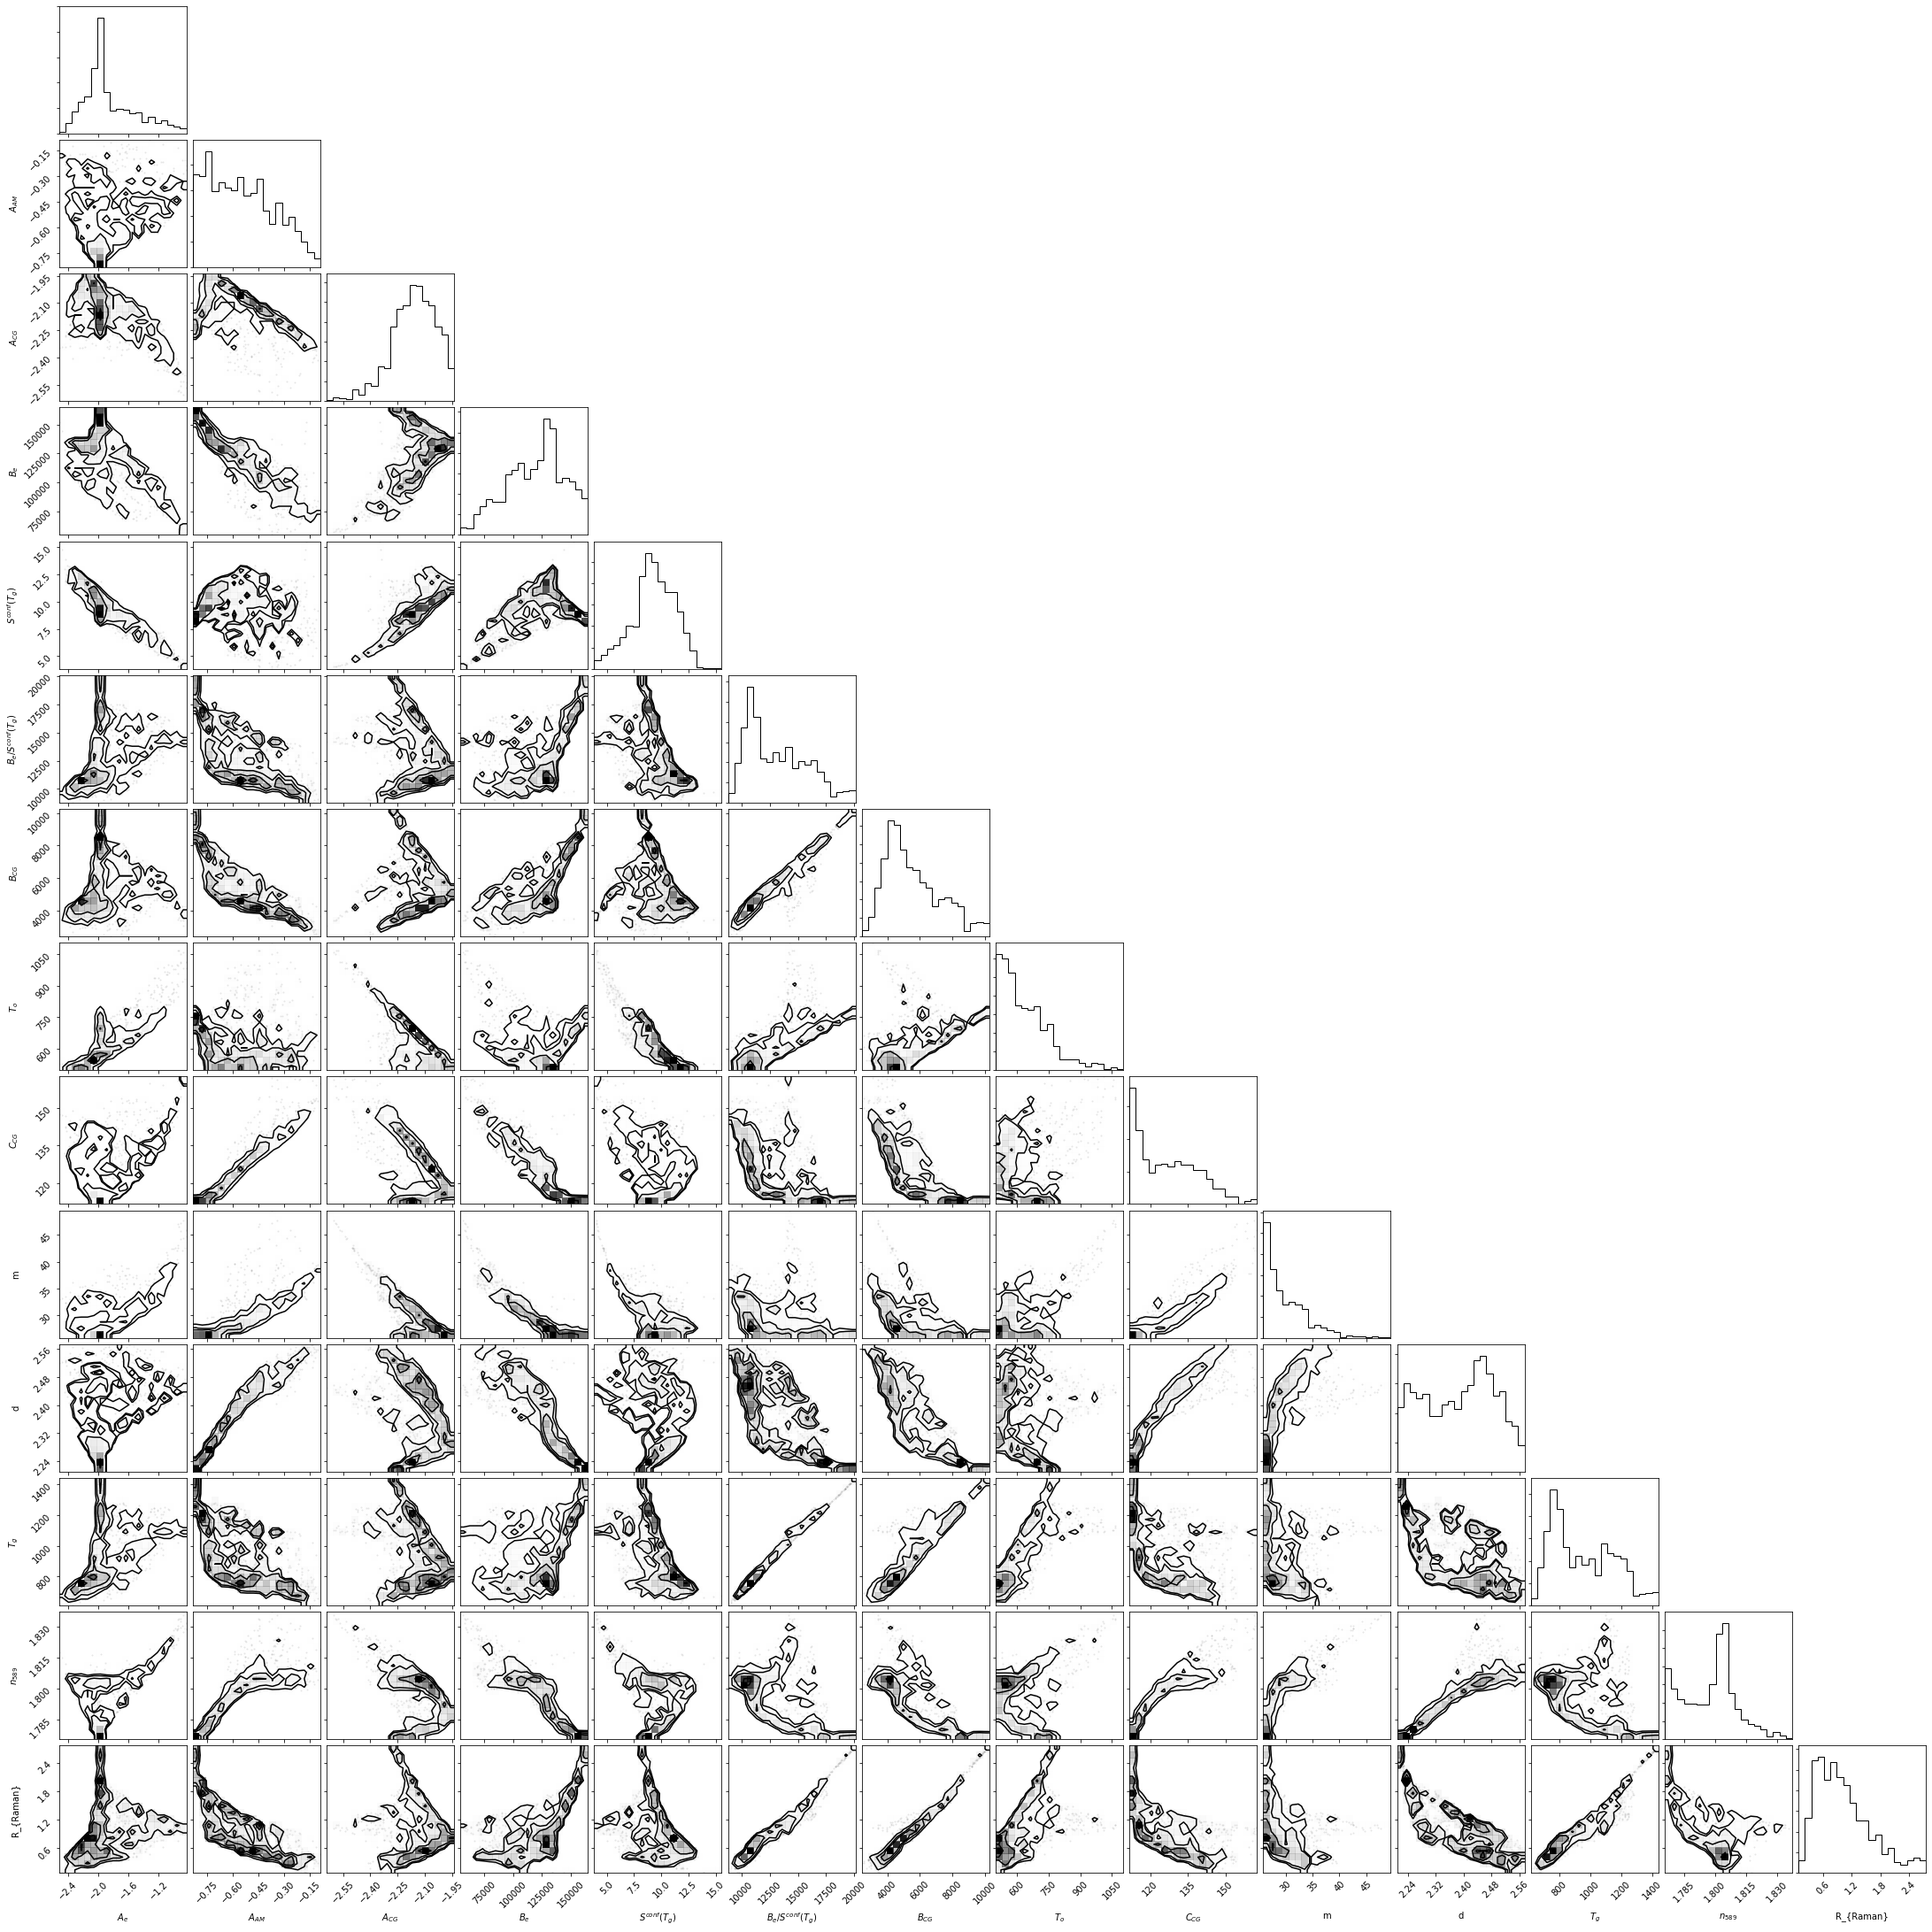

In [12]:
nb_samples = 1000
sio2_gen = np.random.random_sample(nb_samples)*0.5 + 0.5

reminder = 1.0 - sio2_gen

R_MAl = np.random.random_sample(nb_samples)*(1.0-0.4) + 0.4 # ratio of alkalis to Al

R_XK = np.random.random_sample(nb_samples) # ratio K/(K+Na)

al2o3_gen = (1.0 - R_MAl)*reminder

reminder = 1 - sio2_gen - al2o3_gen

na2o_gen = reminder*(1.0-R_XK)
k2o_gen = 1 - sio2_gen - al2o3_gen - na2o_gen

X_gen = pd.DataFrame()
X_gen["sio2"] = sio2_gen
X_gen["al2o3"] = al2o3_gen
X_gen["na2o"] = na2o_gen
X_gen["k2o"] = k2o_gen
X_rec = X_gen.copy()
X_gen = torch.Tensor(X_gen.values).to(device)

Raman_gen = neuralmodel.raman_pred(torch.FloatTensor(X_gen).to(device)).cpu().detach().numpy()

Rr_gen = np.trapz(Raman_gen[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(Raman_gen[:,x_raman_shift>860],x_raman_shift[x_raman_shift>860],axis=1)

samples = np.concatenate((neuralmodel.ae(X_gen).detach().numpy(),
                          neuralmodel.a_am(X_gen).detach().numpy(),
                          neuralmodel.a_cg(X_gen).detach().numpy(),
                          neuralmodel.be(X_gen).detach().numpy(),
                          neuralmodel.sctg(X_gen).detach().numpy(),
                          neuralmodel.be(X_gen).detach().numpy()/neuralmodel.sctg(X_gen).detach().numpy(),
                          neuralmodel.b_cg(X_gen).detach().numpy(),
                          neuralmodel.to_cg(X_gen).detach().numpy(),
                          neuralmodel.c_cg(X_gen).detach().numpy(),
                          neuralmodel.fragility(X_gen).detach().numpy(),
                          neuralmodel.density(X_gen).detach().numpy(),
                          neuralmodel.tg(X_gen).detach().numpy(),
                          neuralmodel.sellmeier(X_gen,torch.FloatTensor(589*np.ones((len(X_gen),1))).to(device)).detach().numpy(),
                          Rr_gen.reshape(-1,1)
                         ),axis=1)

labels = [r"$A_e$", r"$A_{AM}$", r"$A_{CG}$", 
          r"$B_e$", r"$S^{conf}(T_g)$", r"$B_e/S^{conf}(T_g)$", 
          r"$B_{CG}$", r"$T_o$", r"$C_{CG}$", 
          r"m", r"d", r"$T_g$",r"$n_{589}$",r"R_{Raman}"]

import corner

plt.figure(figsize=(15,15))
corner.corner(samples, labels=labels)

plt.savefig("./figures/Correlations.pdf")

 12%|█▏        | 115/1000 [00:00<00:00, 1144.59it/s]

R Rr - Tg = [[1.         0.94412084]
 [0.94412084 1.        ]]


100%|██████████| 1000/1000 [00:00<00:00, 1004.32it/s]


R Rr - Bcg = [[1.         0.97225638]
 [0.97225638 1.        ]]


100%|██████████| 1000/1000 [00:01<00:00, 839.94it/s]


R Rr - Be/Sc = [[1.         0.97278227]
 [0.97278227 1.        ]]


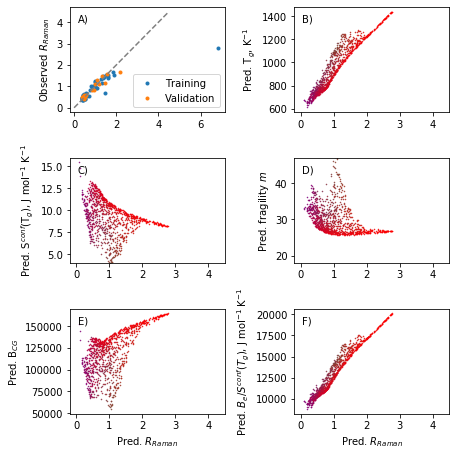

In [13]:
from tqdm import tqdm 

def plot_colored_markers(XXX, YYY, CLR):
    for i in tqdm(range(len(XXX))):
        plt.plot(XXX[i],YYY[i],".",markersize=1,color=(CLR[i,0],CLR[i,1],CLR[i,2]+CLR[i,3]))

plt.figure(figsize=(6.44,6.44))

plt.subplot(3,2,1)

plt.plot(Rr_train,Rr_train_pred,".",color="C0",alpha=1,label="Training")
plt.plot(Rr_valid,Rr_valid_pred,".",color="C1",alpha=1,label="Validation")
plt.plot([0,4.5],[0,4.5],"--",color="grey")

plt.xlim(-0.2,)
plt.ylim(-0.2,)
plt.ylabel("Observed $R_{Raman}$")
plt.legend(loc="lower right")

plt.annotate("A)",xy=(0.05,0.85),xycoords="axes fraction",ha="left")

plt.subplot(3,2,2)
plot_colored_markers(Rr_gen.reshape(-1,1), neuralmodel.tg(X_gen).detach().numpy(), X_gen.detach().numpy())
print("R Rr - Tg = {}".format(np.corrcoef(np.concatenate((Rr_gen.reshape(-1,1), neuralmodel.tg(X_gen).detach().numpy()),axis=1).T)))

plt.annotate("B)",xy=(0.05,0.85),xycoords="axes fraction",ha="left")

plt.xlim(-0.2,4.5)
plt.ylabel(r"Pred. T$_{g}$, K$^{-1}$")

plt.subplot(3,2,3)
plot_colored_markers(Rr_gen.reshape(-1,1), neuralmodel.sctg(X_gen).detach().numpy(), X_gen.detach().numpy())

plt.xlim(-0.2,4.5)
plt.ylim(4,16)
#plt.xlabel("Pred. $R_{Raman}$")
plt.ylabel(r"Pred. S$^{conf}$(T$_{g}$), J mol$^{-1}$ K$^{-1}$")

plt.annotate("C)",xy=(0.05,0.85),xycoords="axes fraction",ha="left")

plt.subplot(3,2,4)
plot_colored_markers(Rr_gen.reshape(-1,1), neuralmodel.fragility(X_gen).detach().numpy(), X_gen.detach().numpy())

plt.xlim(-0.2,4.5)
plt.ylim(18,47)
#plt.xlabel("Pred. $R_{Raman}$")
plt.ylabel(r"Pred. fragility $m$")

#plt.ylim(5,14)

plt.annotate("D)",xy=(0.05,0.85),xycoords="axes fraction",ha="left")

plt.tight_layout()

plt.subplot(3,2,5)
plot_colored_markers(Rr_gen.reshape(-1,1), neuralmodel.be(X_gen).detach().numpy(), X_gen.detach().numpy())
print("R Rr - Bcg = {}".format(np.corrcoef(np.concatenate((Rr_gen.reshape(-1,1), neuralmodel.b_cg(X_gen).detach().numpy()),axis=1).T)))

plt.xlim(-0.2,4.5)
#plt.ylim(18,47)
plt.xlabel("Pred. $R_{Raman}$")
plt.ylabel(r"Pred. B$_{CG}$")

#plt.ylim(5,14)

plt.annotate("E)",xy=(0.05,0.85),xycoords="axes fraction",ha="left")

plt.tight_layout()

plt.subplot(3,2,6)
plot_colored_markers(Rr_gen.reshape(-1,1), neuralmodel.be(X_gen).detach().numpy()/neuralmodel.sctg(X_gen).detach().numpy(), X_gen.detach().numpy())
print("R Rr - Be/Sc = {}".format(np.corrcoef(np.concatenate((Rr_gen.reshape(-1,1), neuralmodel.be(X_gen).detach().numpy()/neuralmodel.sctg(X_gen).detach().numpy()),axis=1).T)))

plt.xlim(-0.2,4.5)

plt.xlabel("Pred. $R_{Raman}$")
plt.ylabel(r"Pred. $B_e/S^{conf}(T_g)$, J mol$^{-1}$ K$^{-1}$")

#plt.ylim(5,14)

plt.annotate("F)",xy=(0.05,0.85),xycoords="axes fraction",ha="left")

plt.tight_layout()
plt.savefig("./figures/Raman_m_Tg.pdf")

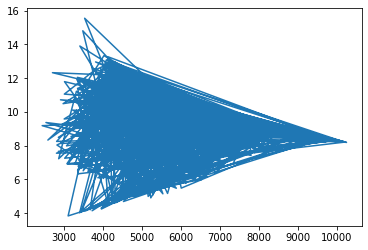

In [14]:
plt.plot(neuralmodel.b_cg(X_gen).detach().numpy(),neuralmodel.sctg(X_gen).detach().numpy())#/neuralmodel.sctg(X_gen).detach().numpy())



array([[1.        , 0.97182157],
       [0.97182157, 1.        ]])

# Ternary plots

In [92]:
def polycorners(ncorners=3):
    '''
    Return 2D cartesian coordinates of a regular convex polygon of a specified
    number of corners.
    Args:
        ncorners (int, optional) number of corners for the polygon (default 3).
    Returns:
        (ncorners, 2) np.ndarray of cartesian coordinates of the polygon.
    '''

    center = np.array([0.5, 0.5])
    points = []

    for i in range(ncorners):
        angle = (float(i) / ncorners) * (np.pi * 2) + (np.pi / 2)
        x = center[0] + np.cos(angle) * 0.5
        y = center[1] + np.sin(angle) * 0.5
        points.append(np.array([x, y]))

    return np.array(points)

def bary2cart(bary, corners):
    '''
    Convert barycentric coordinates to cartesian coordinates given the
    cartesian coordinates of the corners.
    Args:
        bary (np.ndarray): barycentric coordinates to convert. If this matrix
            has multiple rows, each row is interpreted as an individual
            coordinate to convert.
        corners (np.ndarray): cartesian coordinates of the corners.
    Returns:
        2-column np.ndarray of cartesian coordinates for each barycentric
        coordinate provided.
    '''

    cart = None

    if len(bary.shape) > 1 and bary.shape[1] > 1:
        cart = np.array([np.sum(b / np.sum(b) * corners.T, axis=1) for b in bary])
    else:
        cart = np.sum(bary / np.sum(bary) * corners.T, axis=1)

    return cart


In [93]:
#
# For entropy map of NAS AND KAS
#
nb_samples = 10000

sio2_gen = np.random.random_sample(nb_samples)*0.5 + 0.5
reminder = 1.0 - sio2_gen
R_MAl = np.random.random_sample(nb_samples)*(1.0-0.4) + 0.4 # ratio of alkalis to Al
al2o3_gen = (1.0 - R_MAl)*reminder
na2o_gen = 1 - sio2_gen - al2o3_gen
k2o_gen = 1 - sio2_gen - al2o3_gen

X_gen_NAS = pd.DataFrame()
X_gen_NAS["sio2"] = sio2_gen
X_gen_NAS["al2o3"] = al2o3_gen
X_gen_NAS["na2o"] = na2o_gen
X_gen_NAS["k2o"] = 0.0
X_gen_NAS_rec = X_gen_NAS.copy()

X_gen_KAS = X_gen_NAS.copy()
X_gen_KAS["k2o"] = k2o_gen
X_gen_KAS["na2o"] = 0.0
X_gen_KAS_rec = X_gen_KAS.copy()

frames = [X_gen_NAS_rec, X_gen_KAS_rec]

X_gen_NAS = torch.Tensor(X_gen_NAS.values).to(device)
X_gen_KAS = torch.Tensor(X_gen_KAS.values).to(device)
X_gen_all = torch.Tensor(pd.concat(frames).values).to(device)

cart_NAS = bary2cart(X_gen_NAS_rec.loc[:,["na2o","sio2","al2o3"]].values, corners=np.array([[0,0],[1,1],[2,0]]))
cart_KAS = bary2cart(X_gen_KAS_rec.loc[:,["k2o","sio2","al2o3"]].values, corners=np.array([[0,0],[1,1],[2,0]]))

#
# For entropy map during mixing
#

def generate_compo(sio2,R_MAl):
    
    xk = np.linspace(0.,1.,500)

    master_df = pd.DataFrame()
    master_df['sio2'] = sio2[0]*np.ones(500)
    reminder = 1 - master_df['sio2']
    master_df['al2o3'] = R_MAl * reminder
    alkalis = 1 - master_df['sio2'] - master_df['al2o3']
    master_df['na2o'] = (1-xk)*alkalis
    master_df['k2o'] = xk*alkalis
    master_df['xk'] = xk
    
    for i in range(1,len(sio2)):
        ddd = pd.DataFrame()
        ddd['sio2'] = sio2[i]*np.ones(500)
        reminder = 1 - ddd['sio2']
        ddd['al2o3'] = R_MAl * reminder
        alkalis = 1 - ddd['sio2'] - ddd['al2o3']
        ddd['na2o'] = (1-xk)*alkalis
        ddd['k2o'] = xk*alkalis
        ddd['xk'] = xk
        
        master_df = pd.concat([master_df,ddd])
        
    return master_df
        
sio2_gen = np.arange(0.5,0.99,0.01)

X_gen_RS_Xk_rec = generate_compo(sio2_gen, 0.0)
X_gen_R3_Xk_rec = generate_compo(sio2_gen, 0.25)
X_gen_R1_Xk_rec = generate_compo(sio2_gen, 0.5)


# Maps of entropy

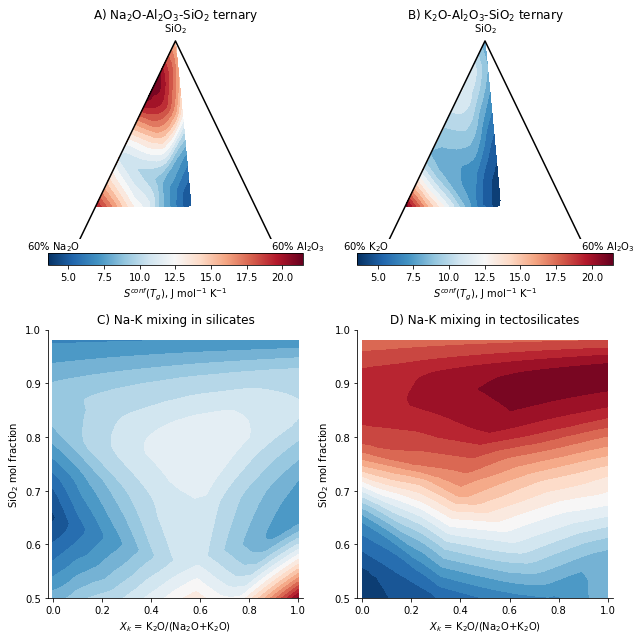

In [94]:
plt.figure(figsize=(9,9))

# grabing the entropies along NS/KS
sctg_NAS = neuralmodel.sctg(torch.FloatTensor(X_gen_NAS).to(device)).cpu().detach().numpy()
sctg_KAS = neuralmodel.sctg(torch.FloatTensor(X_gen_KAS).to(device)).cpu().detach().numpy()
sctg_all = neuralmodel.sctg(torch.FloatTensor(X_gen_all).to(device)).cpu().detach().numpy()

# grabing the entropies for the mixtures
sctg_RS_Xk = neuralmodel.sctg(torch.FloatTensor(X_gen_RS_Xk_rec.loc[:,["sio2","al2o3","na2o","k2o"]].values).to(device)).cpu().detach().numpy()
sctg_R3_Xk = neuralmodel.sctg(torch.FloatTensor(X_gen_R3_Xk_rec.loc[:,["sio2","al2o3","na2o","k2o"]].values).to(device)).cpu().detach().numpy()
sctg_R1_Xk = neuralmodel.sctg(torch.FloatTensor(X_gen_R1_Xk_rec.loc[:,["sio2","al2o3","na2o","k2o"]].values).to(device)).cpu().detach().numpy()

trig_color_plot = sctg_all # for the colors > same scale 

# norm is a class which, when called, can normalize data into the
# [0.0, 1.0] interval.
norm = matplotlib.colors.Normalize(
    vmin=np.min(trig_color_plot),
    vmax=np.max(trig_color_plot))

c_m = matplotlib.cm.RdBu_r # choose a colormap
s_m = matplotlib.cm.ScalarMappable(cmap=c_m, norm=norm) # create a ScalarMappable and initialize a data structure

####
#### TERNARY PLOT NAS
####
ax= plt.subplot(2,2,1)
tc1 = plt.tricontourf(cart_NAS[:,0], 
                cart_NAS[:,1], 
                sctg_NAS[:,0], 
                levels=20, cmap="RdBu_r")

#ax.scatter(cart_NAS[:,0],cart_NAS[:,1],s=1,c="k", cmap="RdBu_r")
ax.plot([0,1,2,0],[0,1,0,0],"k-")

ax.set_xlim(0.2,1.8)
ax.set_ylim(0.4,1.05)

plt.annotate(r"SiO$_2$", xy = (1,1.03),xycoords="data",ha="center")
plt.annotate(r"60% Al$_2$O$_3$", xy = (1.6,0.4),xycoords="data",ha="left",va="top")
plt.annotate(r"60% Na$_2$O", xy = (0.4,0.4),xycoords="data",ha="right",va="top")

ax.axis("off")

cbar_0 = plt.colorbar(mappable=s_m,orientation="horizontal",pad=0.05)
cbar_0.set_label(r"$S^{conf}(T{_g})$, J mol$^{-1}$ K$^{-1}$")

ax.set_title("A) Na$_2$O-Al$_2$O$_3$-SiO$_2$ ternary", loc='center')

plt.tight_layout()

####
#### TERNARY PLOT KAS
####
ax= plt.subplot(2,2,2)
tc1 = plt.tricontourf(cart_KAS[:,0], 
                cart_KAS[:,1], 
                sctg_KAS[:,0], 
                levels=20, cmap="RdBu_r")

#ax.scatter(cart_NAS[:,0],cart_NAS[:,1],s=1,c="k", cmap="RdBu_r")
ax.plot([0,1,2,0],[0,1,0,0],"k-")

ax.set_xlim(0.2,1.8)
ax.set_ylim(0.4,1.05)

plt.annotate(r"SiO$_2$", xy = (1,1.03),xycoords="data",ha="center")
plt.annotate(r"60% Al$_2$O$_3$", xy = (1.6,0.4),xycoords="data",ha="left",va="top")
plt.annotate(r"60% K$_2$O", xy = (0.4,0.4),xycoords="data",ha="right",va="top")

ax.axis("off")
 
cbar_0 = plt.colorbar(mappable=s_m,orientation="horizontal",pad=0.05)
cbar_0.set_label(r"$S^{conf}(T{_g})$, J mol$^{-1}$ K$^{-1}$")

ax.set_title("B) K$_2$O-Al$_2$O$_3$-SiO$_2$ ternary", loc='center')

plt.tight_layout()

####
#### XK along near tectosilicate joint
####
ax= plt.subplot(2,2,3)
tc1 = plt.tricontourf(X_gen_RS_Xk_rec.loc[:,"xk"], 
                X_gen_RS_Xk_rec.loc[:,"sio2"], 
                sctg_RS_Xk[:,0], 
                levels=20, cmap="RdBu_r")

#ax.scatter(cart_KAS[:,0],cart_KAS[:,1],s=1,c="k", cmap="RdBu_r")
ax.set_xlim(-0.02,1.02)
ax.set_ylim(0.5,1.)

plt.xlabel(r"$X_k$ = K$_2$O/(Na$_2$O+K$_2$O)")
plt.ylabel(r"SiO$_2$ mol fraction")

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#ax.axis('off') 
#cbar_0 = plt.colorbar(mappable=s_m,orientation="horizontal",pad=0.05)
#cbar_0.set_label(r"$S^{conf}(T{_g})$, J mol$^{-1}$ K$^{-1}$")

ax.set_title("C) Na-K mixing in silicates", loc='center')

plt.tight_layout()

####
#### XK along near tectosilicate joint
####
ax= plt.subplot(2,2,4)
tc1 = plt.tricontourf(X_gen_R1_Xk_rec.loc[:,"xk"], 
                X_gen_R1_Xk_rec.loc[:,"sio2"], 
                sctg_R1_Xk[:,0], 
                levels=20, cmap="RdBu_r")

#ax.scatter(cart_KAS[:,0],cart_KAS[:,1],s=1,c="k", cmap="RdBu_r")
ax.set_xlim(-0.02,1.02)
ax.set_ylim(0.5,1.)

plt.xlabel(r"$X_k$ = K$_2$O/(Na$_2$O+K$_2$O)")
plt.ylabel(r"SiO$_2$ mol fraction")

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#cbar_0 = plt.colorbar(mappable=s_m,orientation="vertical",pad=0.05)
#cbar_0.set_label(r"$S^{conf}(T{_g})$, J mol$^{-1}$ K$^{-1}$")

ax.set_title("D) Na-K mixing in tectosilicates", loc='center')

plt.tight_layout()

plt.savefig("./figures/entro_maps.pdf")

# Maps of fragility, density, refractive index

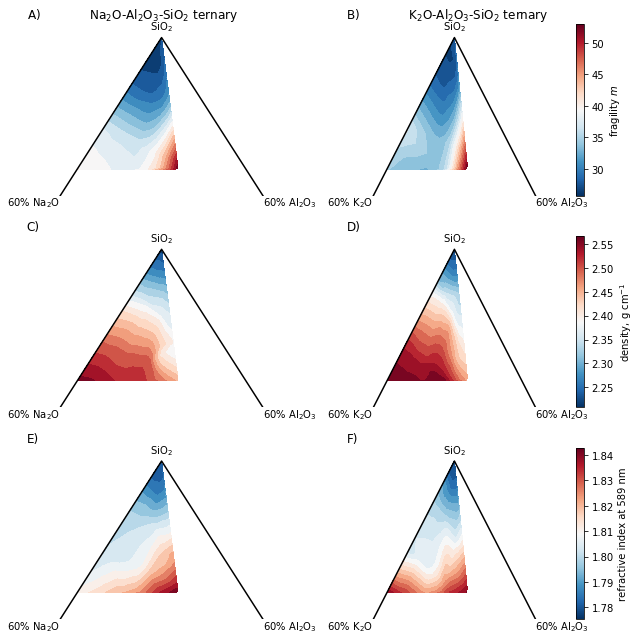

In [113]:
plt.figure(figsize=(9,9))

# grabing the predictions in NAS and KAS
m_NAS = neuralmodel.fragility(torch.FloatTensor(X_gen_NAS).to(device)).cpu().detach().numpy()
m_KAS = neuralmodel.fragility(torch.FloatTensor(X_gen_KAS).to(device)).cpu().detach().numpy()
m_all = neuralmodel.fragility(torch.FloatTensor(X_gen_all).to(device)).cpu().detach().numpy()

d_NAS = neuralmodel.density(torch.FloatTensor(X_gen_NAS).to(device)).cpu().detach().numpy()
d_KAS = neuralmodel.density(torch.FloatTensor(X_gen_KAS).to(device)).cpu().detach().numpy()
d_all = neuralmodel.density(torch.FloatTensor(X_gen_all).to(device)).cpu().detach().numpy()

n_NAS = neuralmodel.sellmeier(torch.FloatTensor(X_gen_NAS).to(device),torch.FloatTensor(np.ones((len(X_gen_NAS),1))*593.0).to(device)).cpu().detach().numpy()
n_KAS = neuralmodel.sellmeier(torch.FloatTensor(X_gen_KAS).to(device),torch.FloatTensor(np.ones((len(X_gen_KAS),1))*593.0).to(device)).cpu().detach().numpy()
n_all = neuralmodel.sellmeier(torch.FloatTensor(X_gen_all).to(device),torch.FloatTensor(np.ones((len(X_gen_all),1))*593.0).to(device)).cpu().detach().numpy()

# choose a colormap
c_m = matplotlib.cm.RdBu_r 

#### Scalar Mappables for color bars
s_m = matplotlib.cm.ScalarMappable(cmap=c_m, 
                                   norm=matplotlib.colors.Normalize(
                                                                    vmin=np.min(m_all),
                                                                    vmax=np.max(m_all))) # create a ScalarMappable and initialize a data structure
s_d = matplotlib.cm.ScalarMappable(cmap=c_m, 
                                   norm=matplotlib.colors.Normalize(
                                                                    vmin=np.min(d_all),
                                                                    vmax=np.max(d_all))) # create a ScalarMappable and initialize a data structure

s_n = matplotlib.cm.ScalarMappable(cmap=c_m, 
                                   norm=matplotlib.colors.Normalize(
                                                                    vmin=np.min(n_all),
                                                                    vmax=np.max(n_all))) # create a ScalarMappable and initialize a data structure

####
#### NAS FRAGILITY TERNARY PLOT
####
ax= plt.subplot(3,2,1)

tc1 = plt.tricontourf(cart_NAS[:,0], cart_NAS[:,1], m_NAS[:,0], levels=20, cmap="RdBu_r")
ax.plot([0,1,2,0],[0,1,0,0],"k-")
#cbar_0 = plt.colorbar(mappable=s_m,orientation="horizontal",pad=0.05)
#cbar_0.set_label(r"fragility $m$")

ax.axis("off")
ax.set_xlim(0.2,1.8)
ax.set_ylim(0.4,1.05)

plt.annotate(r"SiO$_2$", xy = (1,1.03),xycoords="data",ha="center")
plt.annotate(r"60% Al$_2$O$_3$", xy = (1.6,0.4),xycoords="data",ha="left",va="top")
plt.annotate(r"60% Na$_2$O", xy = (0.4,0.4),xycoords="data",ha="right",va="top")
ax.set_title("A)             Na$_2$O-Al$_2$O$_3$-SiO$_2$ ternary", loc='left')

plt.tight_layout()

####
#### KAS FRAGILITY TERNARY PLOT
####
ax= plt.subplot(3,2,2)

tc1 = plt.tricontourf(cart_KAS[:,0], cart_KAS[:,1], m_KAS[:,0], levels=20, cmap="RdBu_r")
ax.plot([0,1,2,0],[0,1,0,0],"k-")
cbar_0 = plt.colorbar(mappable=s_m,orientation="vertical",pad=0.05)
cbar_0.set_label(r"fragility $m$")

ax.axis("off")
ax.set_xlim(0.2,1.8)
ax.set_ylim(0.4,1.05)

plt.annotate(r"SiO$_2$", xy = (1,1.03),xycoords="data",ha="center")
plt.annotate(r"60% Al$_2$O$_3$", xy = (1.6,0.4),xycoords="data",ha="left",va="top")
plt.annotate(r"60% K$_2$O", xy = (0.4,0.4),xycoords="data",ha="right",va="top")
ax.set_title("B)             K$_2$O-Al$_2$O$_3$-SiO$_2$ ternary", loc='left')

plt.tight_layout()

####
#### NAS DENSITY TERNARY PLOT
####
ax= plt.subplot(3,2,3)
tc1 = plt.tricontourf(cart_NAS[:,0], cart_NAS[:,1], d_NAS[:,0], levels=20, cmap="RdBu_r")
ax.plot([0,1,2,0],[0,1,0,0],"k-")
#cbar_0 = plt.colorbar(mappable=s_d,orientation="horizontal",pad=0.05)
#cbar_0.set_label(r"density, g cm$^{-1}$")

ax.axis("off")
ax.set_xlim(0.2,1.8)
ax.set_ylim(0.4,1.05)

plt.annotate(r"SiO$_2$", xy = (1,1.03),xycoords="data",ha="center")
plt.annotate(r"60% Al$_2$O$_3$", xy = (1.6,0.4),xycoords="data",ha="left",va="top")
plt.annotate(r"60% Na$_2$O", xy = (0.4,0.4),xycoords="data",ha="right",va="top")
ax.set_title("C)", loc='left')

plt.tight_layout()

####
#### KAS DENSITY TERNARY PLOT
####
ax= plt.subplot(3,2,4)
tc1 = plt.tricontourf(cart_KAS[:,0], cart_KAS[:,1], d_KAS[:,0], levels=20, cmap="RdBu_r")
ax.plot([0,1,2,0],[0,1,0,0],"k-")
cbar_0 = plt.colorbar(mappable=s_d,orientation="vertical",pad=0.05)
cbar_0.set_label(r"density, g cm$^{-1}$")

ax.axis("off")
ax.set_xlim(0.2,1.8)
ax.set_ylim(0.4,1.05)

plt.annotate(r"SiO$_2$", xy = (1,1.03),xycoords="data",ha="center")
plt.annotate(r"60% Al$_2$O$_3$", xy = (1.6,0.4),xycoords="data",ha="left",va="top")
plt.annotate(r"60% K$_2$O", xy = (0.4,0.4),xycoords="data",ha="right",va="top")
ax.set_title("D)", loc='left')

plt.tight_layout()

####
#### NAS OPTIC TERNARY PLOT
####
ax= plt.subplot(3,2,5)
tc1 = plt.tricontourf(cart_NAS[:,0], cart_NAS[:,1], n_NAS[:,0], levels=20, cmap="RdBu_r")
ax.plot([0,1,2,0],[0,1,0,0],"k-")
#cbar_0 = plt.colorbar(mappable=s_n,orientation="horizontal",pad=0.05)
#cbar_0.set_label(r"m")

ax.axis("off")
ax.set_xlim(0.2,1.8)
ax.set_ylim(0.4,1.05)

plt.annotate(r"SiO$_2$", xy = (1,1.03),xycoords="data",ha="center")
plt.annotate(r"60% Al$_2$O$_3$", xy = (1.6,0.4),xycoords="data",ha="left",va="top")
plt.annotate(r"60% Na$_2$O", xy = (0.4,0.4),xycoords="data",ha="right",va="top")
ax.set_title("E)", loc='left')

plt.tight_layout()

####
#### KAS FRAGILITY TERNARY PLOT
####
ax= plt.subplot(3,2,6)
tc1 = plt.tricontourf(cart_KAS[:,0], cart_KAS[:,1], n_KAS[:,0], levels=20, cmap="RdBu_r")
ax.plot([0,1,2,0],[0,1,0,0],"k-")
cbar_0 = plt.colorbar(mappable=s_n,orientation="vertical",pad=0.05)
cbar_0.set_label(r"refractive index at 589 nm")

ax.axis("off")
ax.set_xlim(0.2,1.8)
ax.set_ylim(0.4,1.05)

plt.annotate(r"SiO$_2$", xy = (1,1.03),xycoords="data",ha="center")
plt.annotate(r"60% Al$_2$O$_3$", xy = (1.6,0.4),xycoords="data",ha="left",va="top")
plt.annotate(r"60% K$_2$O", xy = (0.4,0.4),xycoords="data",ha="right",va="top")

ax.set_title("F)", loc='left')

plt.tight_layout()

plt.savefig("./figures/fragility_maps.pdf")

# Map for fragility vs XK

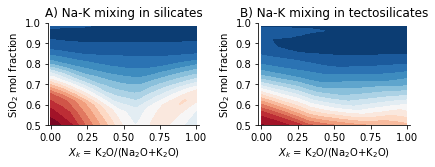

In [114]:
# grabing the entropies for the mixtures
m_RS_Xk = neuralmodel.fragility(torch.FloatTensor(X_gen_RS_Xk_rec.loc[:,["sio2","al2o3","na2o","k2o"]].values).to(device)).cpu().detach().numpy()
m_R3_Xk = neuralmodel.fragility(torch.FloatTensor(X_gen_R3_Xk_rec.loc[:,["sio2","al2o3","na2o","k2o"]].values).to(device)).cpu().detach().numpy()
m_R1_Xk = neuralmodel.fragility(torch.FloatTensor(X_gen_R1_Xk_rec.loc[:,["sio2","al2o3","na2o","k2o"]].values).to(device)).cpu().detach().numpy()


####
#### XK along near tectosilicate joint
####
ax= plt.subplot(2,2,3)
tc1 = plt.tricontourf(X_gen_RS_Xk_rec.loc[:,"xk"], 
                X_gen_RS_Xk_rec.loc[:,"sio2"], 
                m_RS_Xk[:,0], 
                levels=20, cmap="RdBu_r")

#ax.scatter(cart_KAS[:,0],cart_KAS[:,1],s=1,c="k", cmap="RdBu_r")
ax.set_xlim(-0.02,1.02)
ax.set_ylim(0.5,1.)

plt.xlabel(r"$X_k$ = K$_2$O/(Na$_2$O+K$_2$O)")
plt.ylabel(r"SiO$_2$ mol fraction")

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#ax.axis('off') 
#cbar_0 = plt.colorbar(mappable=s_m,orientation="horizontal",pad=0.05)
#cbar_0.set_label(r"$S^{conf}(T{_g})$, J mol$^{-1}$ K$^{-1}$")

ax.set_title("A) Na-K mixing in silicates", loc='center')

plt.tight_layout()

####
#### XK along near tectosilicate joint
####
ax= plt.subplot(2,2,4)
tc1 = plt.tricontourf(X_gen_R1_Xk_rec.loc[:,"xk"], 
                X_gen_R1_Xk_rec.loc[:,"sio2"], 
                m_R1_Xk[:,0], 
                levels=20, cmap="RdBu_r")

#ax.scatter(cart_KAS[:,0],cart_KAS[:,1],s=1,c="k", cmap="RdBu_r")
ax.set_xlim(-0.02,1.02)
ax.set_ylim(0.5,1.)

plt.xlabel(r"$X_k$ = K$_2$O/(Na$_2$O+K$_2$O)")
plt.ylabel(r"SiO$_2$ mol fraction")

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#cbar_0 = plt.colorbar(mappable=s_m,orientation="vertical",pad=0.05)
#cbar_0.set_label(r"$S^{conf}(T{_g})$, J mol$^{-1}$ K$^{-1}$")

ax.set_title("B) Na-K mixing in tectosilicates", loc='center')

plt.tight_layout()

In [46]:
Tecto_KAS = pd.DataFrame()
Tecto_KAS["sio2"] = np.arange(.6,0.8,0.01)
Tecto_KAS["al2o3"] = np.linspace(.2,0.1,num=len(Tecto_KAS.sio2))
Tecto_KAS["na2o"] = np.zeros(len(Tecto_KAS.sio2))
Tecto_KAS["k2o"] = np.linspace(.2,0.1,num=len(Tecto_KAS.sio2))
Tecto_KAS_Raman = neuralmodel.raman_pred(torch.FloatTensor(Tecto_KAS.values).to(device)).cpu().detach().numpy()
Tecto_KAS_sconf = neuralmodel.sctg(torch.FloatTensor(Tecto_KAS.values).to(device)).cpu().detach().numpy()
Tecto_KAS_tg = neuralmodel.tg(torch.FloatTensor(Tecto_KAS.values).to(device)).cpu().detach().numpy()
Tecto_KAS_tg = neuralmodel.tg(torch.FloatTensor(Tecto_KAS.values).to(device)).cpu().detach().numpy()
Tecto_KAS_Rr = np.trapz(Tecto_KAS_Raman[:,x_raman_shift<670],x_raman_shift[x_raman_shift<670],axis=1)/np.trapz(Tecto_KAS_Raman[:,x_raman_shift>800],x_raman_shift[x_raman_shift>800],axis=1)

Tecto_NAS = pd.DataFrame()
Tecto_NAS["sio2"] = np.arange(.6,0.8,0.01)
Tecto_NAS["al2o3"] = np.linspace(.2,0.1,num=len(Tecto_NAS.sio2))
Tecto_NAS["na2o"] = np.linspace(.2,0.1,num=len(Tecto_NAS.sio2)) 
Tecto_NAS["k2o"] = np.zeros(len(Tecto_NAS.sio2))
Tecto_NAS_Raman = neuralmodel.raman_pred(torch.FloatTensor(Tecto_NAS.values).to(device)).cpu().detach().numpy()
Tecto_NAS_sconf = neuralmodel.tg(torch.FloatTensor(Tecto_NAS.values).to(device)).cpu().detach().numpy()

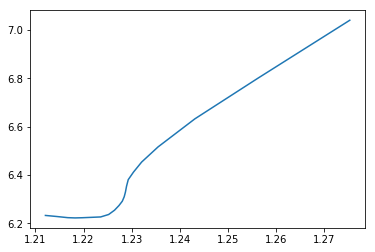

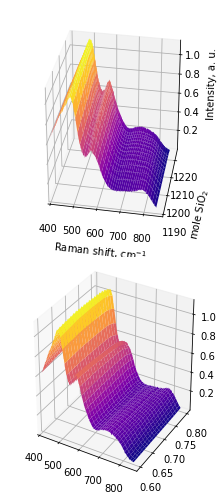

In [34]:
from mpl_toolkits.mplot3d import Axes3D

lb = 200
hb = 850

fig = plt.figure(figsize=(3.22,7))
ax_3d_1 = fig.add_subplot(211, projection='3d')
ax_3d_2 = fig.add_subplot(212, projection='3d')

ax_3d_1.plot_surface( (x_raman_shift.reshape(1,-1)*np.ones((21,850)))[:,(lb<x_raman_shift)&(x_raman_shift<hb)],
                     Tecto_KAS_sconf[:,0].reshape(-1,1)*np.ones((21,850))[:,(lb<x_raman_shift)&(x_raman_shift<hb)],
                     #(Tecto_KAS.values[:,0].reshape(-1,1)*np.ones((21,850)))[:,(lb<x_raman_shift)&(x_raman_shift<hb)], 
                     Tecto_KAS_Raman[:,(lb<x_raman_shift)&(x_raman_shift<hb)],
                     cmap="plasma")
ax_3d_1.set_xlim(400,)
ax_3d_1.view_init(30, -80)

ax_3d_1.set_xlabel("Raman shift, cm$^{-1}$")
ax_3d_1.set_ylabel("mole SiO$_2$",labelpad=10)
ax_3d_1.set_zlabel("Intensity, a. u.",labelpad=10)

ax_3d_2.plot_surface((x_raman_shift.reshape(1,-1)*np.ones((21,850)))[:,(lb<x_raman_shift)&(x_raman_shift<hb)], 
                  (Tecto_KAS.values[:,0].reshape(-1,1)*np.ones((21,850)))[:,(lb<x_raman_shift)&(x_raman_shift<hb)], 
                  Tecto_KAS_Raman[:,(lb<x_raman_shift)&(x_raman_shift<hb)],
               cmap="plasma")
ax_3d_2.set_xlim(400,)
ax_3d_2.view_init(30, -60)

plt.tight_layout()

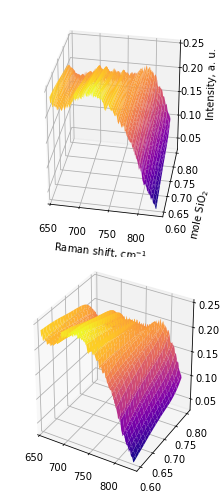

In [15]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(3.22,7))
ax_3d_1 = fig.add_subplot(211, projection='3d')
ax_3d_2 = fig.add_subplot(212, projection='3d')

ax_3d_1.plot_surface( (x_raman_shift.reshape(1,-1)*np.ones((21,850)))[:,(650<x_raman_shift)&(x_raman_shift<830)], 
                  (Tecto_KAS.values[:,0].reshape(-1,1)*np.ones((21,850)))[:,(650<x_raman_shift)&(x_raman_shift<830)], 
                  Tecto_KAS_Raman[:,(650<x_raman_shift)&(x_raman_shift<830)],
               cmap="plasma")
ax_3d_1.set_xlim(650,)
ax_3d_1.view_init(30, -80)

ax_3d_1.set_xlabel("Raman shift, cm$^{-1}$")
ax_3d_1.set_ylabel("mole SiO$_2$",labelpad=10)
ax_3d_1.set_zlabel("Intensity, a. u.",labelpad=10)

ax_3d_2.plot_surface((x_raman_shift.reshape(1,-1)*np.ones((21,850)))[:,(650<x_raman_shift)&(x_raman_shift<830)], 
                  (Tecto_KAS.values[:,0].reshape(-1,1)*np.ones((21,850)))[:,(650<x_raman_shift)&(x_raman_shift<830)], 
                  Tecto_KAS_Raman[:,(650<x_raman_shift)&(x_raman_shift<830)],
               cmap="plasma")
ax_3d_2.set_xlim(650,)
ax_3d_2.view_init(30, -60)

plt.tight_layout()

In [64]:
Tecto_KAS.values[:,0].reshape(-1,1)*np.ones((21,850))

array([[0.6 , 0.6 , 0.6 , ..., 0.6 , 0.6 , 0.6 ],
       [0.61, 0.61, 0.61, ..., 0.61, 0.61, 0.61],
       [0.62, 0.62, 0.62, ..., 0.62, 0.62, 0.62],
       ...,
       [0.78, 0.78, 0.78, ..., 0.78, 0.78, 0.78],
       [0.79, 0.79, 0.79, ..., 0.79, 0.79, 0.79],
       [0.8 , 0.8 , 0.8 , ..., 0.8 , 0.8 , 0.8 ]])

In [63]:
plt.tricontour(.ravel(),Tecto_KAS.values[:,0].reshape(-1,1)*np.ones((21,850)).ravel())

ValueError: operands could not be broadcast together with shapes (1,850) (17850,) 

# Density RMSE on test set

In [22]:
diff = mean_squared_error(ds.y_density_test.cpu().detach().numpy(),neuralmodel.density(ds.x_density_test).cpu().detach().numpy())
print(np.sqrt(diff))

0.013789135


0.00035614707


In [139]:
np.where(diff>0.02)

(array([9]), array([0]))

In [140]:
X_density_valid[9,:]

array([0.72, 0.07, 0.  , 0.07])

In [28]:
Raman_error*100

2.6895329799680483